In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from rubin_sim.maf import radar
import os

from matplotlib.legend_handler import HandlerErrorbar

In [2]:
def norm_df(
    df,
    runs,
    cols,
    norm_run="baseline",
    invert_cols=None,
    reverse_cols=None,
    run_label="run_name",
    mag_cols=[],
):
    """
    Normalize values in a dataframe to a given run
    Parameters
    ----------
    df : pandas.DataFrame
        The input data frame
    runs : list of str
        A list of run numes
    cols : list of str
        A list of columns in df to use
    norm_run : str
        The row to use to normalize things to
    invert_cols : list of str
        A list of column names that should be inverted (e.g., columns that
        are uncertainties and are better with a smaller value)
    reverse_cols : list of str
        Columns to reverse (e.g., magnitudes)
    run_label : str (run_name)
        The column that has run names
    mag_cols : list of str
        Columns that are in magnitudes
    """
    indices = [np.max(np.where(df.index == name)[0]) for name in runs]
    out_df = df[cols].iloc[indices].copy()
    if reverse_cols is not None:
        for colname in reverse_cols:
            out_df[colname] = -out_df[colname]
    if invert_cols is not None:
        for colname in invert_cols:
            out_df[colname] = 1.0 / out_df[colname]
    if norm_run is not None:
        indx = np.max(np.where(out_df.index == norm_run)[0])
        for col in out_df.columns:
            # maybe just check that it's not a
            if col != "run_name":
                if (col in mag_cols) | (mag_cols == "all"):
                    out_df[col] = 1.0 + (out_df[col] - out_df[col].iloc[indx])
                else:
                    out_df[col] = (
                        1.0
                        + (out_df[col] - out_df[col].iloc[indx])
                        / out_df[col].iloc[indx]
                    )
    return out_df

In [3]:

data_loaded = pd.read_hdf('summary.h5')
data_loaded.shape

(71, 79133)

In [4]:
#[col for col in data_loaded.columns if 'LVDwarfs' in col]
#[col for col in data_loaded.columns if 'KNePop' in col and 'Total detected' in col and 'ztfrest_simple ' in col and 'DD' in col ]
[col for col in data_loaded.columns if 'Footprint' in col ]

['FootprintFraction N year 1 g and night < 365 HealpixSlicer',
 'FootprintFraction N year 1 i and night < 365 HealpixSlicer',
 'FootprintFraction N year 1 r and night < 365 HealpixSlicer',
 'FootprintFraction N year 1 u and night < 365 HealpixSlicer',
 'FootprintFraction N year 1 y and night < 365 HealpixSlicer',
 'FootprintFraction N year 1 z and night < 365 HealpixSlicer',
 'Sum GalplaneFootprintMetric_bonito_sfr_map_Tau_11_0 HealpixSlicer',
 'Sum GalplaneFootprintMetric_bonito_sfr_map_Tau_20_0 HealpixSlicer',
 'Sum GalplaneFootprintMetric_bonito_sfr_map_Tau_2_0 HealpixSlicer',
 'Sum GalplaneFootprintMetric_bonito_sfr_map_Tau_46_5 HealpixSlicer',
 'Sum GalplaneFootprintMetric_bonito_sfr_map_Tau_5_0 HealpixSlicer',
 'Sum GalplaneFootprintMetric_bonito_sfr_map_Tau_73_0 HealpixSlicer',
 'Sum GalplaneFootprintMetric_bonito_sfr_map_n_obs HealpixSlicer',
 'Sum GalplaneFootprintMetric_bonito_sfr_map_n_obs_priority HealpixSlicer',
 'Sum GalplaneFootprintMetric_clementini_stellarpops_map_Tau_

In [5]:
# Pull out the metrics we are interested in and define simple names

name_dict = {'FootprintFraction N year 1 u and night < 365 HealpixSlicer': 'Y1,u',
            'FootprintFraction N year 1 g and night < 365 HealpixSlicer': 'Y1,g',
            'FootprintFraction N year 1 r and night < 365 HealpixSlicer': 'Y1,r',

            'FootprintFraction N year 1 i and night < 365 HealpixSlicer': 'Y1,i',
    'best18k Parallax fiveSigmaDepth, filter, seeingFwhmGeom, ra_pi_amp, dec_pi_amp HealpixSlicer': 'parallax best 18k',
            'best18k properMotion HealpixSlicer': 'proper motion best 18k',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 20_30 days UserPointsSlicer': '20-30d microlensing\ndetection',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 60_90 days UserPointsSlicer': '60-90d microlensing\ndetection',
            'fONv MedianNvis fO HealpixSlicer': 'fO N vis',
            'Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer': 'SNe, N',
             'Median SNNSNMetric_reducezlim DDF excluded HealpixSlicer': 'SNe, zlim',
            '3x2ptFoM Exgalm5WithCuts i band non-DD year 10 HealpixSlicer': '3x2 i-band',
            'Median WeakLensingNvisits gri band non-DD HealpixSlicer': 'WL Nvis \ni-band',
            'Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer': 'KNe ZTF simple',
            'Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer': 'KNe single model',
            'Sum PrestoKNe_score_p UserPointsSlicer': 'KNe Score, P',
            'Total detected XRBPopMetric_early_detect UserPointsSlicer': 'XRB\nearly detect',
            'VolumeSum Brown Dwarf, L7 HealpixSlicer': 'Brown Dwarf Vol',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO bright',
            'CumulativeCompleteness H <= 22.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO faint',
            'CumulativeCompleteness H <= 6.000000 DiscoveryNChances TNO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'TNO',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances MBA 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'MBA',
            'CumulativeCompleteness H <= 18.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'Trojan',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 1 quad in 1 night detection loss MoObjSlicer': 'Vatira',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances PHA 1 quad in 1 night detection loss MoObjSlicer': 'PHA, quad'}
            
# drop in the units for the columns
units = {'parallax best 18k': 'mas',
         'proper motion best 18k': 'mas/yr',
         '20-30d microlensing\ndetection': 'fraction', 
         '60-90d microlensing\ndetection': 'fraction', 
         'fO N vis' : '', 
         'SNe, N': '', 
         'SNe, zlim': '', 
         '3x2 i-band': 'score', 
         'WL Nvis \ni-band': '', 
         'KNe ZTF simple': 'N', 
         'KNe single model': 'N',
         'KNe Score, P': 'score',
         'XRB\nearly detect': 'N', 
         'Brown Dwarf Vol': 'pc^3', 
         'NEO bright': 'fraction', 
         'NEO faint': 'fraction', 
         'TNO': 'fraction', 
         'MBA':'fraction',
         'Trojan': 'fraction',
         'Vatira': 'fraction',
         'PHA, quad': 'fraction',
         'Y1,u': '',
         'Y1,g': '',
         'Y1,r': '',
         'Y1,i': '',
        }

# If columns are uncertainties, we want to plot them backwards
invert_cols = ['parallax best 18k', 'proper motion best 18k']
# If columns are mags or fractions, we want to plot differences, not fractional differences.
mag_cols = ['20-30d microlensing\ndetection', '60-90d microlensing\ndetection','SNe, zlim',
            'NEO bright', 'NEO faint', 'TNO', 'Vatira', 'MBA', 'Trojan']

data = pd.DataFrame()
for key in name_dict:
    data[name_dict[key]] = data_loaded[key]
    

mag_dict = {'Median CoaddM5 g HealpixSlicer': 'g',
 'Median CoaddM5 i HealpixSlicer': 'i',
 'Median CoaddM5 r HealpixSlicer': 'r',
 'Median CoaddM5 u HealpixSlicer': 'u',
 'Median CoaddM5 y HealpixSlicer': 'y',
 'Median CoaddM5 z HealpixSlicer': 'z'}

mag_data = pd.DataFrame()
for key in mag_dict:
    mag_data[mag_dict[key]] = data_loaded[key]
    
    
    
ddf_dict = {'Sum SNNSNMetric DD:COSMOS_reducen_sn DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN COSMOS',
           'Sum SNNSNMetric DD:ECDFS_reducen_sn DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ECDFS',
           'Sum SNNSNMetric DD:EDFS_reducen_sn DD:EDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN EDFS',
           'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ELAISS1',
           'Sum SNNSNMetric DD:XMM_LSS_reducen_sn DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN XMM_LSS',
            
           'Median SNNSNMetric DD:COSMOS_reducezlim DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer': 'zlim COSMOS',
            'Median SNNSNMetric DD:ECDFS_reducezlim DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim ECDFS',
            'Median SNNSNMetric DD:EDFS_reducezlim DD:EDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim EDFS',
            'Median SNNSNMetric DD:ELAISS1_reducezlim DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer': 'zlim ELAISS1',
            'Median SNNSNMetric DD:XMM_LSS_reducezlim DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer': 'zlim XMM_LSS',
            
           'Total detected KNePopMetric_DD:COSMOS_ztfrest_simple DD:COSMOS UserPointsSlicer': 'Kne COSMOS',
         'Total detected KNePopMetric_DD:ECDFS_ztfrest_simple DD:ECDFS UserPointsSlicer': 'Kne ECDFS',
 'Total detected KNePopMetric_DD:EDFS_ztfrest_simple DD:EDFS UserPointsSlicer': 'Kne EDFS',
 'Total detected KNePopMetric_DD:ELAISS1_ztfrest_simple DD:ELAISS1 UserPointsSlicer': 'Kne ELAISS1',
 'Total detected KNePopMetric_DD:WFD_ztfrest_simple DD:WFD UserPointsSlicer': 'Kne WFD',
 'Total detected KNePopMetric_DD:XMM_LSS_ztfrest_simple DD:XMM_LSS UserPointsSlicer': 'Kne XMM_LSS',
            
            'Median DD:COSMOS NVisits all bands HealpixSubsetSlicer':'N COSMOS',
 'Median DD:ECDFS NVisits all bands HealpixSubsetSlicer': 'N ECDFS',
 'Median DD:EDFS NVisits all bands HealpixSubsetSlicer': 'N EDFS',
 'Median DD:ELAISS1 NVisits all bands HealpixSubsetSlicer': 'N ELAISS1',
 'Median DD:WFD NVisits all bands HealpixSubsetSlicer': 'N WFD',
 'Median DD:XMM_LSS NVisits all bands HealpixSubsetSlicer': 'N XMM_LSS', 
           }

ddf_data = pd.DataFrame()
for key in ddf_dict:
    ddf_data[ddf_dict[key]] = data_loaded[key]
 
gaps_dict = {}
for filtername in 'ugrizy':
    for times in [3,7,24]:
        gaps_dict['Mean N gaps in %s at %ihr in top 18k Gaps_%ihr %s band HealpixSlicer'% (filtername, times, times, filtername)] = 'gaps %s %i' % (filtername, times)
        #gaps_dict['Mean Gaps_%ihr %s band HealpixSlicer' % (times, filtername)] = 'gaps %s %i' % (filtername, times)
        
gaps_data = pd.DataFrame()
for key in gaps_dict:
    gaps_data[gaps_dict[key]] = data_loaded[key]

In [6]:
#data['KNe single model'] # data['KNe ZTF simple']

In [7]:
# A bit of a mystery why baseline_v3.0_10yrs is so much better. 
# The KNe ZTF simple and KNe single model don't seem to
# be particularly well correlated. Seems like it has to be an MJD_start bug somewhere, but I can't find it.
#data['KNe ZTF simple']

In [8]:
mag_data

g          i          r          u  \
baseline_v2.0_10yrs          26.733479  26.218659  26.755971  25.818916   
baseline_v2.1_10yrs          26.736248  26.252054  26.781543  25.751969   
baseline_v2.2_10yrs          26.753646  26.290929  26.835430  25.724699   
baseline_v3.0_10yrs          26.688123  26.264600  26.818287  25.668262   
baseline_v3.2_10yrs          26.678103  26.295888  26.807880  25.622696   
...                                ...        ...        ...        ...   
weather_cloudso35v3.3_10yrs  26.790232  26.464519  26.931364  25.312661   
weather_cloudso36v3.3_10yrs  26.793997  26.462797  26.943343  25.327536   
weather_cloudso4v3.3_10yrs   26.819778  26.485966  26.961559  25.362218   
weather_cloudso6v3.3_10yrs   26.838073  26.489439  26.972462  25.371837   
weather_cloudso8v3.3_10yrs   26.794823  26.470888  26.948127  25.334447   

                                     y          z  
baseline_v2.0_10yrs          24.762720  25.510379  
baseline_v2.1_10yrs          24.728145  25.486640  
baseline_v2.2_10yrs          24.782743  25.581317  
baseline_v3.0_10yrs          24.756955  25.524781  
baseline_v3.2_10yrs          24.766647  25.586860  
...                                ...        ...  
weather_cloudso35v3.3_10yrs  24.798930  25.750963  
weather_cloudso36v3.3_10yrs  24.800256  25.753877  
weather_cloudso4v3.3_10yrs   24.825912  25.774446  
weather_cloudso6v3.3_10yrs   24.830641  25.784502  
weather_cloudso8v3.3_10yrs   24.818872  25.767303  

[71 rows x 6 columns]

In [9]:
ddf_data
#ddf_data = ddf_data.reindex(new_ind)

N SN COSMOS  N SN ECDFS    N SN EDFS  \
baseline_v2.0_10yrs           638.253284  586.826209   974.231557   
baseline_v2.1_10yrs           548.479625  545.669910   875.981802   
baseline_v2.2_10yrs           708.239238  685.202422  1067.553931   
baseline_v3.0_10yrs           955.159293  799.584601  1266.961769   
baseline_v3.2_10yrs           971.481238  868.593513  1528.851192   
...                                  ...         ...          ...   
weather_cloudso35v3.3_10yrs   994.332538  882.774905  1477.116209   
weather_cloudso36v3.3_10yrs  1035.262128  870.548111  1470.734572   
weather_cloudso4v3.3_10yrs   1026.456529  878.545470  1689.108351   
weather_cloudso6v3.3_10yrs   1057.283189  927.322074  1701.046568   
weather_cloudso8v3.3_10yrs   1010.638220  870.792167  1570.620889   

                             N SN ELAISS1  N SN XMM_LSS  zlim COSMOS  \
baseline_v2.0_10yrs            684.401547    611.229060     0.503926   
baseline_v2.1_10yrs            636.634918    520.071105     0.496150   
baseline_v2.2_10yrs            674.561648    611.247120     0.493897   
baseline_v3.0_10yrs            688.808879    726.491723     0.503734   
baseline_v3.2_10yrs            844.740564    840.405268     0.510969   
...                                   ...           ...          ...   
weather_cloudso35v3.3_10yrs    774.358510    798.435466     0.549817   
weather_cloudso36v3.3_10yrs    846.921687    877.741750     0.538999   
weather_cloudso4v3.3_10yrs     854.328057    935.400085     0.532859   
weather_cloudso6v3.3_10yrs     917.050678    925.669244     0.544843   
weather_cloudso8v3.3_10yrs     829.912606    834.949044     0.541605   

                             zlim ECDFS  zlim EDFS  zlim ELAISS1  \
baseline_v2.0_10yrs            0.485978   0.481621      0.508870   
baseline_v2.1_10yrs            0.484905   0.474738      0.501027   
baseline_v2.2_10yrs            0.495572   0.466223      0.488264   
baseline_v3.0_10yrs            0.521961   0.464010      0.500330   
baseline_v3.2_10yrs            0.550142   0.486932      0.516296   
...                                 ...        ...           ...   
weather_cloudso35v3.3_10yrs    0.540714   0.497212      0.508908   
weather_cloudso36v3.3_10yrs    0.545024   0.501478      0.512564   
weather_cloudso4v3.3_10yrs     0.555736   0.506633      0.519646   
weather_cloudso6v3.3_10yrs     0.557735   0.503299      0.515654   
weather_cloudso8v3.3_10yrs     0.545191   0.493702      0.510004   

                             zlim XMM_LSS  ...  Kne EDFS  Kne ELAISS1  \
baseline_v2.0_10yrs              0.490990  ...     365.0        423.0   
baseline_v2.1_10yrs              0.480094  ...     373.0        384.0   
baseline_v2.2_10yrs              0.484132  ...     425.0        370.0   
baseline_v3.0_10yrs              0.484669  ...     428.0        405.0   
baseline_v3.2_10yrs              0.502590  ...     537.0        455.0   
...                                   ...  ...       ...          ...   
weather_cloudso35v3.3_10yrs      0.500535  ...     567.0        513.0   
weather_cloudso36v3.3_10yrs      0.508370  ...     539.0        513.0   
weather_cloudso4v3.3_10yrs       0.525198  ...     628.0        534.0   
weather_cloudso6v3.3_10yrs       0.510142  ...     623.0        501.0   
weather_cloudso8v3.3_10yrs       0.505807  ...     584.0        516.0   

                             Kne WFD  Kne XMM_LSS  N COSMOS  N ECDFS  N EDFS  \
baseline_v2.0_10yrs            298.0        317.0    8937.5   9264.0  5497.0   
baseline_v2.1_10yrs            289.0        325.0    8900.0   9166.5  5506.0   
baseline_v2.2_10yrs            327.0        304.0    9853.0   9663.0  6150.0   
baseline_v3.0_10yrs            339.0        340.0   18716.5  10606.5  6668.0   
baseline_v3.2_10yrs            392.0        419.0   19496.5  10806.5  6800.0   
...                              ...          ...       ...      ...     ...   
weather_cloudso35v3.3_10yrs    404.0        405.0   18775.0   9939.5  6160.0   
w

In [10]:
gaps_data

gaps u 3  gaps u 7  gaps u 24  gaps g 3  \
baseline_v2.0_10yrs          0.559565  0.096983   2.681121  0.501515   
baseline_v2.1_10yrs          0.601110  0.097077   2.961440  0.621392   
baseline_v2.2_10yrs          0.633655  0.187066   3.622465  0.399776   
baseline_v3.0_10yrs          0.257192  0.257425   3.984706  0.213736   
baseline_v3.2_10yrs          0.140020  0.100247   3.084814  0.605912   
...                               ...       ...        ...       ...   
weather_cloudso35v3.3_10yrs  0.165571  0.100061   4.015200  0.191216   
weather_cloudso36v3.3_10yrs  0.210426  0.120763   4.160768  0.190563   
weather_cloudso4v3.3_10yrs   0.204924  0.124633   3.740477  0.191122   
weather_cloudso6v3.3_10yrs   0.238542  0.101320   4.443932  0.195878   
weather_cloudso8v3.3_10yrs   0.196344  0.102858   3.670630  0.152889   

                             gaps g 7  gaps g 24  gaps r 3  gaps r 7  \
baseline_v2.0_10yrs          0.060381   4.151443  2.579755  0.452371   
baseline_v2.1_10yrs          0.080291   4.104024  2.708024  0.389565   
baseline_v2.2_10yrs          0.051569   4.466172  1.834849  0.314636   
baseline_v3.0_10yrs          0.363687   3.787056  1.069054  1.779876   
baseline_v3.2_10yrs          0.540215   3.727001  1.198583  0.843055   
...                               ...        ...       ...       ...   
weather_cloudso35v3.3_10yrs  0.126171   4.818902  1.969273  1.357626   
weather_cloudso36v3.3_10yrs  0.103278   4.809903  1.859141  1.404672   
weather_cloudso4v3.3_10yrs   0.151816   4.369749  1.952208  1.281065   
weather_cloudso6v3.3_10yrs   0.128876   4.827435  1.915653  1.310813   
weather_cloudso8v3.3_10yrs   0.115494   4.595002  1.759314  1.456894   

                             gaps r 24  gaps i 3  gaps i 7  gaps i 24  \
baseline_v2.0_10yrs          17.055252  2.086213  0.422810  15.289504   
baseline_v2.1_10yrs          18.103231  2.217187  0.366019  16.026064   
baseline_v2.2_10yrs          19.672775  1.433580  0.276449  16.984520   
baseline_v3.0_10yrs          20.989882  1.293328  1.973516  18.047932   
baseline_v3.2_10yrs          20.776752  2.040891  1.196717  19.389239   
...                                ...       ...       ...        ...   
weather_cloudso35v3.3_10yrs  23.403926  1.649788  1.031426  20.628433   
weather_cloudso36v3.3_10yrs  23.208234  1.671935  1.070033  20.660325   
weather_cloudso4v3.3_10yrs   24.274537  1.664662  0.959248  21.120343   
weather_cloudso6v3.3_10yrs   25.205250  1.777451  1.132186  21.719168   
weather_cloudso8v3.3_10yrs   23.858628  1.713013  0.984567  20.813540   

                             gaps z 3  gaps z 7  gaps z 24  gaps y 3  \
baseline_v2.0_10yrs          2.832937  0.465706  18.134005  2.181890   
baseline_v2.1_10yrs          3.008206  0.484776  18.327179  2.477409   
baseline_v2.2_10yrs          2.238075  0.408775  20.773395  1.377629   
baseline_v3.0_10yrs          1.569590  1.366578  22.387886  0.725976   
baseline_v3.2_10yrs          1.162540  0.734229  16.713013  1.363501   
...                               ...       ...        ...       ...   
weather_cloudso35v3.3_10yrs  1.348580  0.796009  18.020049  1.510188   
weather_cloudso36v3.3_10yrs  1.329090  0.793724  17.733716  1.459085   
weather_cloudso4v3.3_10yrs   1.351145  0.800718  17.531263  1.546603   
weather_cloudso6v3.3_10yrs   1.389285  0.948011  18.487714  1.507204   
weather_cloudso8v3.3_10yrs   1.314636  0.814520  17.842216  1.364293   

                             gaps y 7  gaps y 24  
baseline_v2.0_10yrs          0.218119  10.919662  
baseline_v2.1_10yrs          0.206229  10.257798  
baseline_v2.2_10yrs          0.186833   8.640323  
baseline_v3.0_10yrs          0.211312   9.392083  
baseline_v3.2_10yrs          0.541941  13.219471  
...                               ...        ...  
weather_cloudso35v3.3_10yrs  0.616916  15.967734  
weather_cloudso36v3.3_10yrs  0.609409  15.831445  
weather_cloudso4v3.3_10yrs   0.565440  16.074369  
weather_cloudso6v3.3_10yrs   0.682007  16.52007

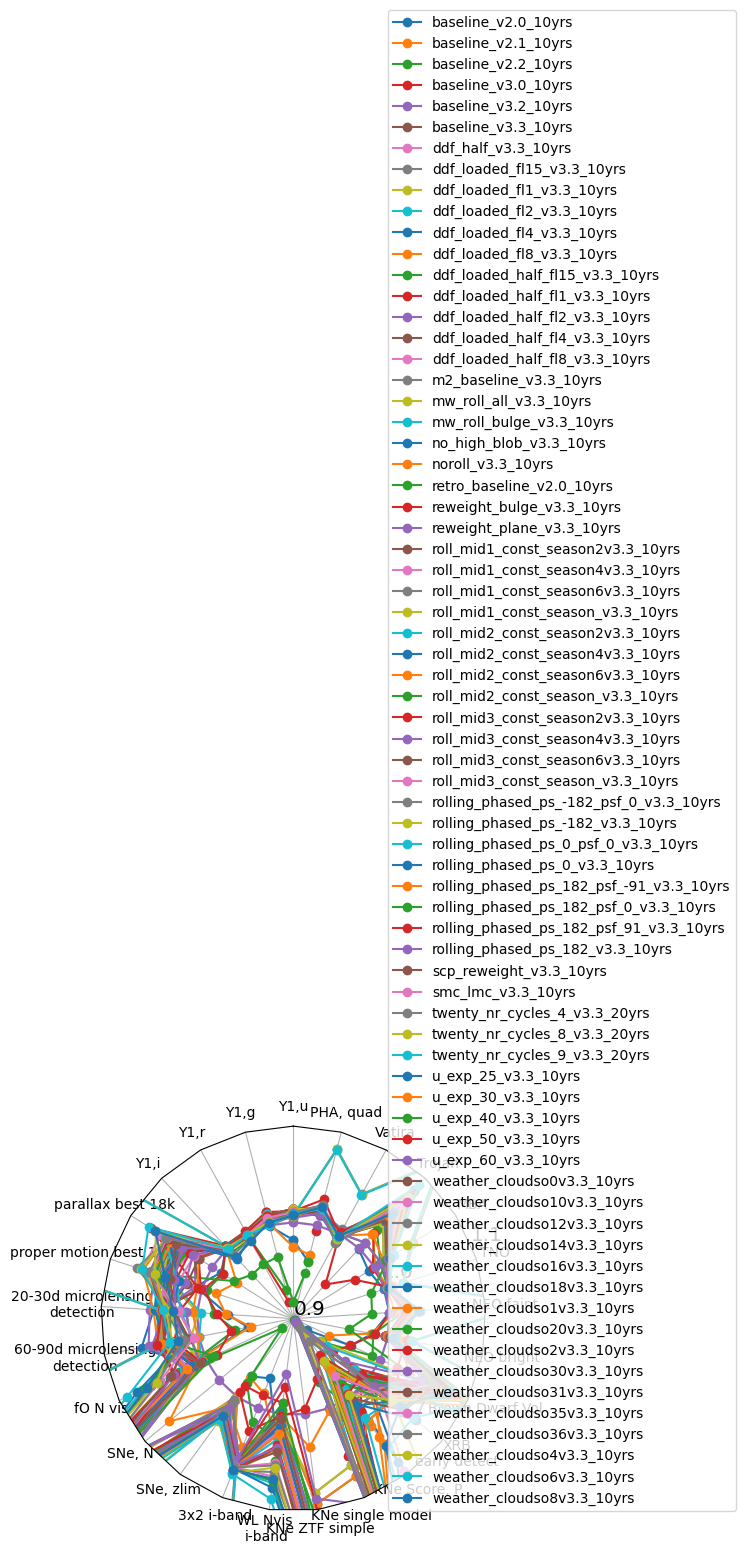

In [11]:
runs = [run for run in data.index ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

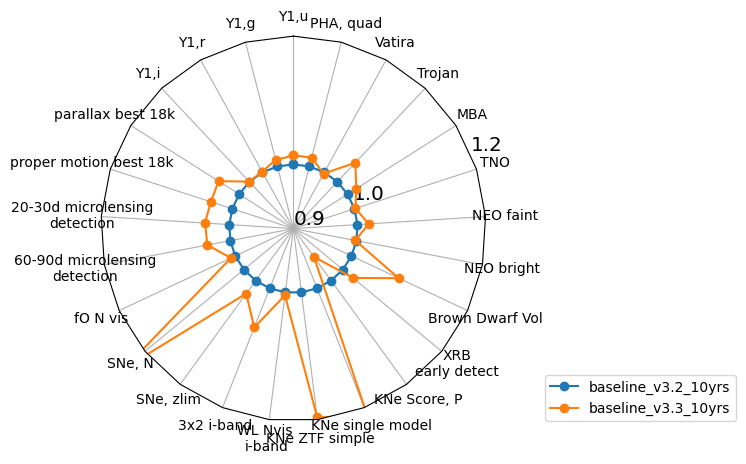

In [12]:
runs = ['baseline_v3.2_10yrs', 'baseline_v3.3_10yrs' ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.2], bbox_to_anchor=(1.65, 0))

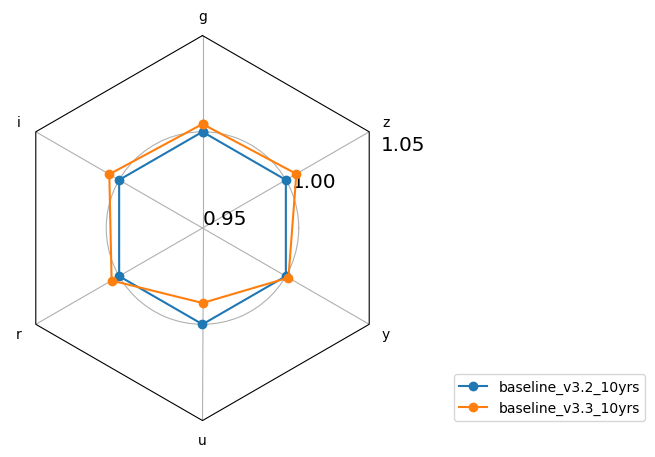

In [13]:
runs = ['baseline_v3.2_10yrs', 'baseline_v3.3_10yrs' ]
ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                 mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.95, 1.0, 1.05], bbox_to_anchor=(1.65, 0))

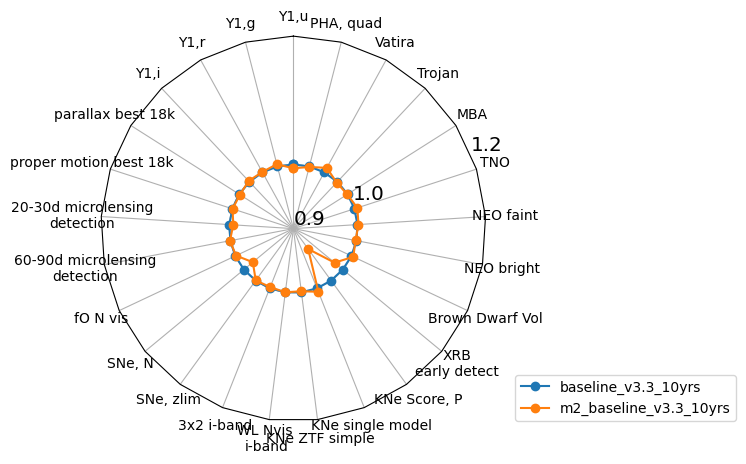

In [14]:
# Look at difference between cluster and Apple chips
runs = ['baseline_v3.3_10yrs', 'm2_baseline_v3.3_10yrs' ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.2], bbox_to_anchor=(1.65, 0))

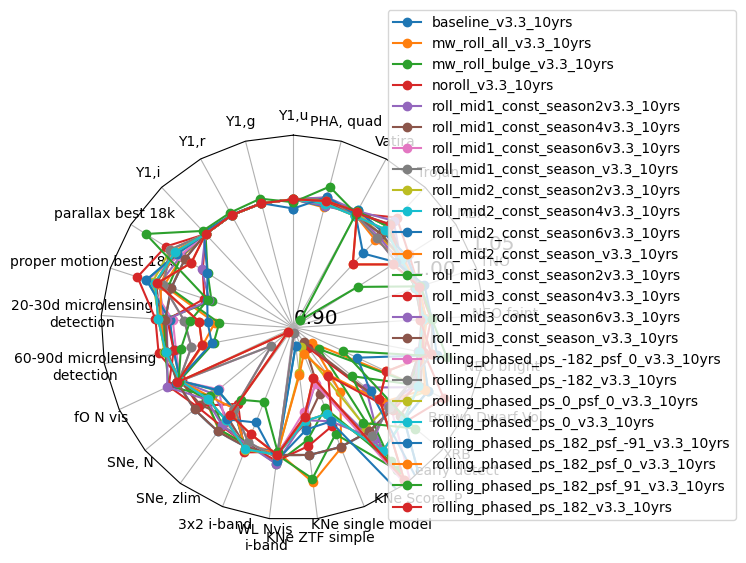

In [15]:
# various rolling
runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'roll' in run]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.90, 1.0, 1.05], bbox_to_anchor=(1.65, 0))

In [16]:


times = ['retro_baseline_v2.0_10yrs', 'baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
        'baseline_v3.0_10yrs',  'baseline_v3.2_10yrs', 'baseline_v3.3_10yrs']

sub_data = data.reindex(labels=times)
sub_ddf = ddf_data.reindex(labels=times)
sub_mag = mag_data.reindex(labels=times)
sub_gaps = gaps_data.reindex(labels=times)
sub_data



Y1,u      Y1,g      Y1,r      Y1,i  \
retro_baseline_v2.0_10yrs  0.893276  0.949104  0.960964  0.958616   
baseline_v2.0_10yrs        0.955776  0.981594  0.994441  0.997035   
baseline_v2.1_10yrs        0.948661  0.984188  0.996912  0.999012   
baseline_v2.2_10yrs        0.871233  0.914268  0.993947  0.998023   
baseline_v3.0_10yrs        0.813058  0.901174  0.993823  0.999135   
baseline_v3.2_10yrs        0.973633  0.982335  0.996170  0.995800   
baseline_v3.3_10yrs        0.987305  0.992712  0.997529  0.996294   

                           parallax best 18k  proper motion best 18k  \
retro_baseline_v2.0_10yrs           0.804328                0.176701   
baseline_v2.0_10yrs                 0.791058                0.184088   
baseline_v2.1_10yrs                 0.806910                0.188258   
baseline_v2.2_10yrs                 0.792958                0.186345   
baseline_v3.0_10yrs                 0.792666                0.185683   
baseline_v3.2_10yrs                 0.782518                0.185369   
baseline_v3.3_10yrs                 0.753823                0.179042   

                           20-30d microlensing\ndetection  \
retro_baseline_v2.0_10yrs                          0.0878   
baseline_v2.0_10yrs                                0.3119   
baseline_v2.1_10yrs                                0.3141   
baseline_v2.2_10yrs                                0.3268   
baseline_v3.0_10yrs                                0.3232   
baseline_v3.2_10yrs                                0.3437   
baseline_v3.3_10yrs                                0.3817   

                           60-90d microlensing\ndetection  fO N vis  \
retro_baseline_v2.0_10yrs                          0.1568     848.0   
baseline_v2.0_10yrs                                0.4348     839.0   
baseline_v2.1_10yrs                                0.4319     838.0   
baseline_v2.2_10yrs                                0.4487     830.0   
baseline_v3.0_10yrs                                0.4528     795.0   
baseline_v3.2_10yrs                                0.4869     805.0   
baseline_v3.3_10yrs                                0.5233     811.0   

                                  SNe, N  ...  KNe Score, P  \
retro_baseline_v2.0_10yrs   97124.012102  ...    202.730488   
baseline_v2.0_10yrs         99302.532220  ...    263.906551   
baseline_v2.1_10yrs         99294.339899  ...    243.713720   
baseline_v2.2_10yrs        112802.099640  ...    242.377184   
baseline_v3.0_10yrs        109475.798536  ...    228.428876   
baseline_v3.2_10yrs        123176.659086  ...    234.851082   
baseline_v3.3_10yrs        152910.228661  ...    224.134552   

                           XRB\nearly detect  Brown Dwarf Vol  NEO bright  \
retro_baseline_v2.0_10yrs              720.0    179640.718155      0.9048   
baseline_v2.0_10yrs                   1882.0    168086.074111      0.9294   
baseline_v2.1_10yrs                   1918.0    163815.013503      0.9286   
baseline_v2.2_10yrs                   1921.0    172453.127988      0.9304   
baseline_v3.0_10yrs                   1952.0    168032.537231      0.9326   
baseline_v3.2_10yrs                   2048.0    174053.517478      0.9460   
baseline_v3.3_10yrs                   2090.0    188222.084374      0.9442   

                           NEO faint       TNO       MBA    Trojan  Vatira  \
retro_baseline_v2.0_10yrs   0.624144  0.705922  0.943673  0.667514  0.0000   
baseline_v2.0_10yrs         0.642165  0.719712  0.919119  0.588234  0.0039   
baseline_v2.1_10yrs         0.647818  0.723396  0.927584  0.609144  0.0017   
baseline_v2.2_10yrs         0.657736  0.723964  0.933674  0.615614  0.0008   
baseline_v3.0_10yrs         0.642444  0.722371  0.924274  0.611475  0.0376   
baseline_v3.2_10yrs         0.642240  0.720853  0.926557  0.589189  0.4628   
baseline_v3.3_10yrs         0.659856  0.722551  0.942687  0.630071  0.4606   

                           PHA, quad  
retro_baseline_v2.0_10yrs   0.847855  
baseline_v2.0_10yr

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_48677/3763499284.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',


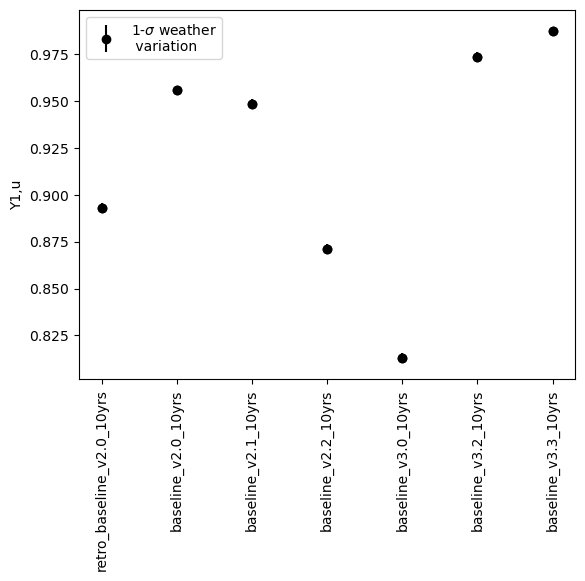

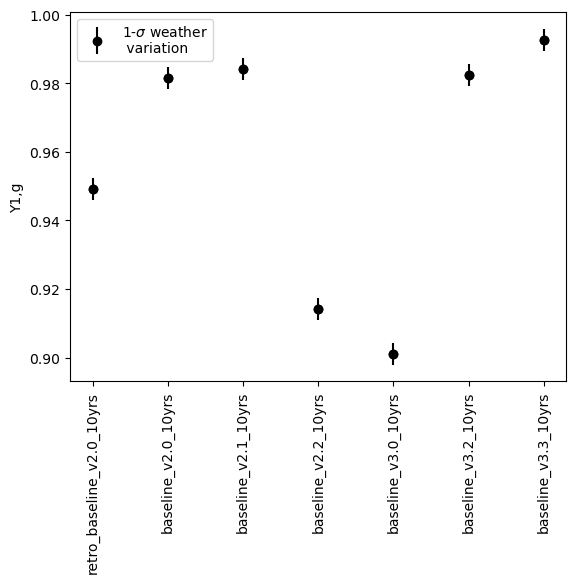

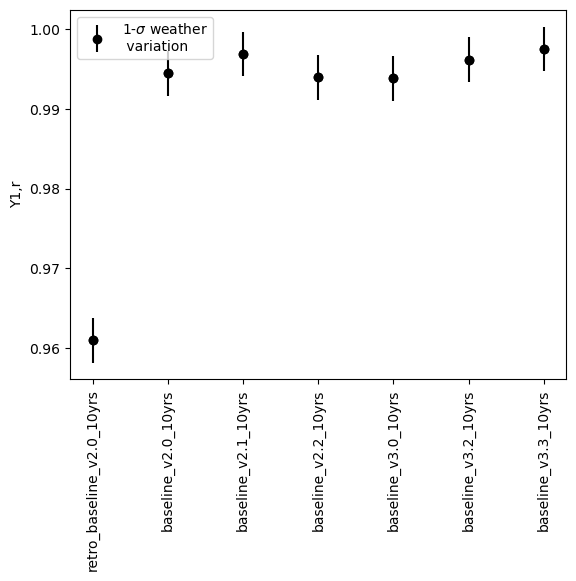

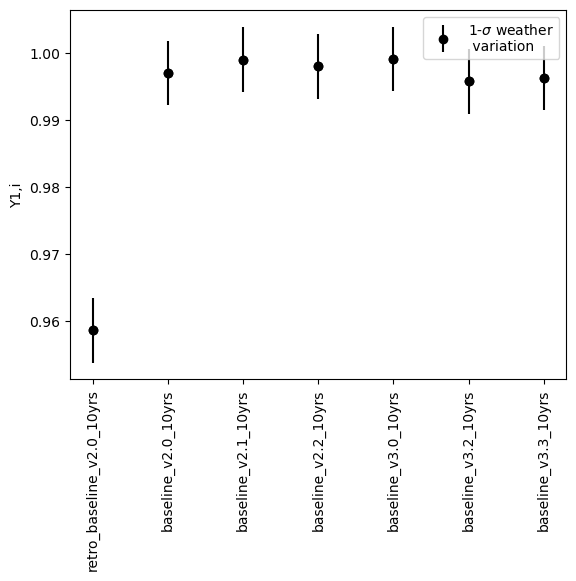

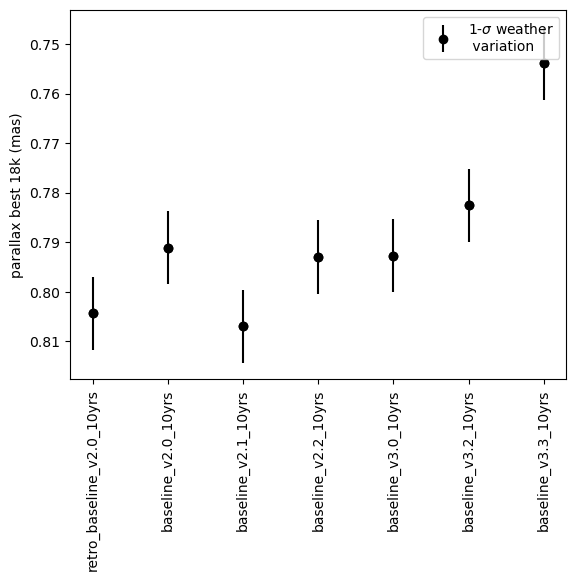

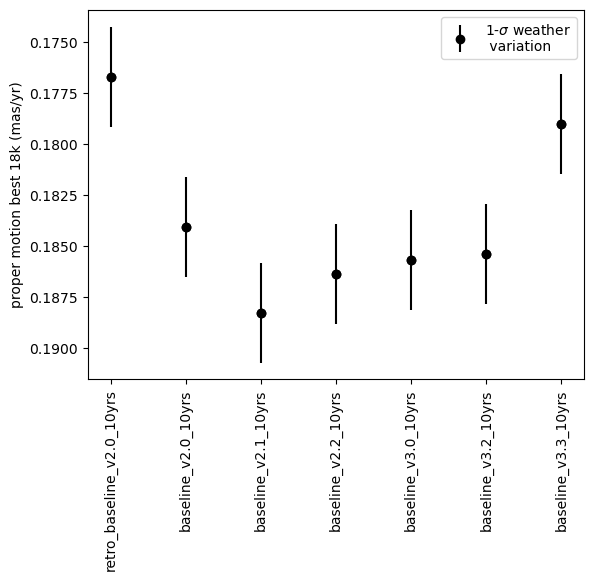

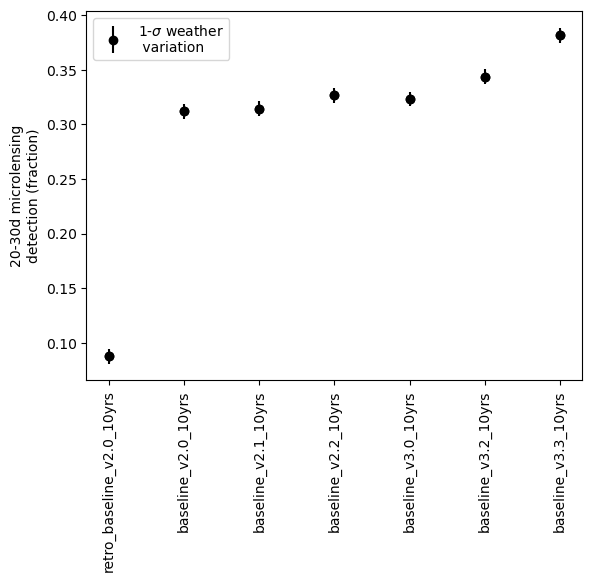

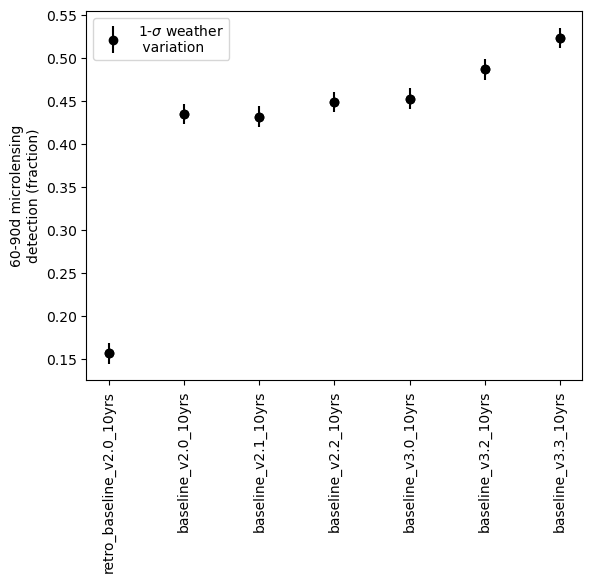

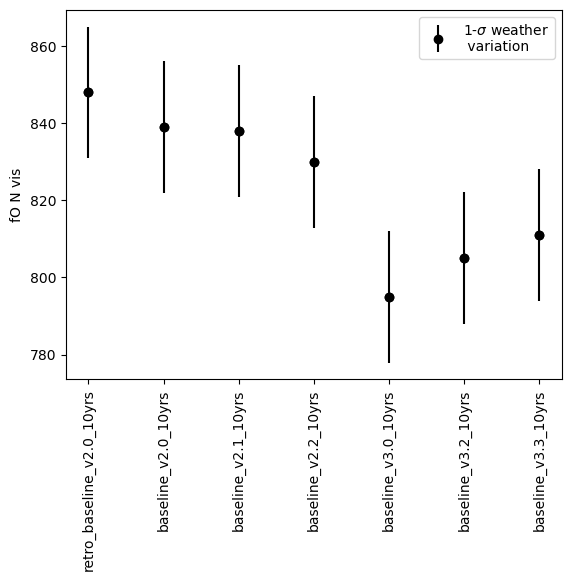

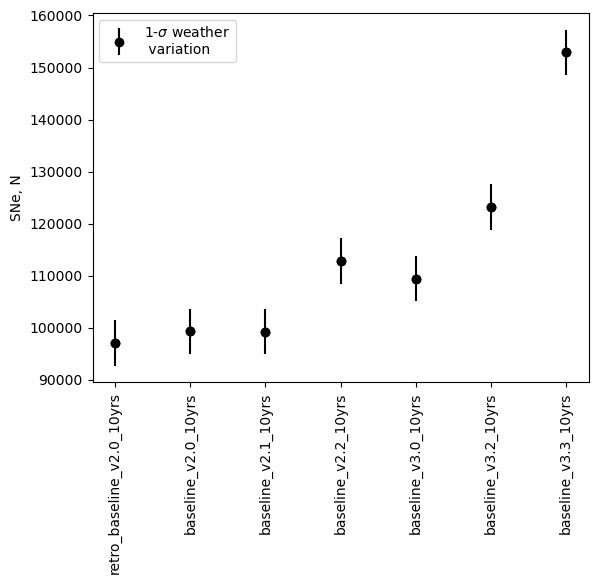

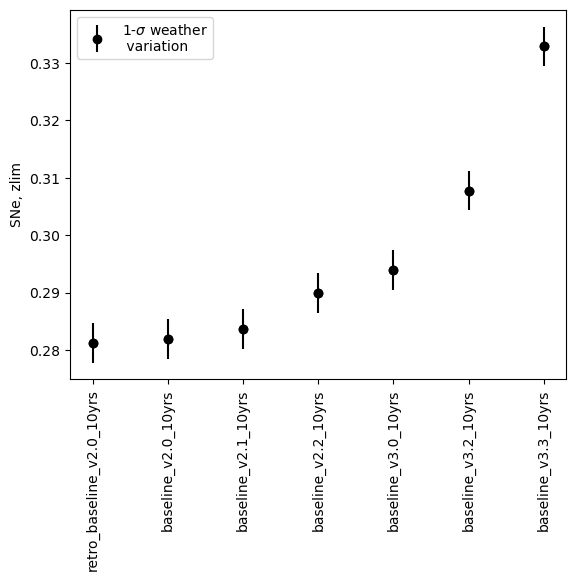

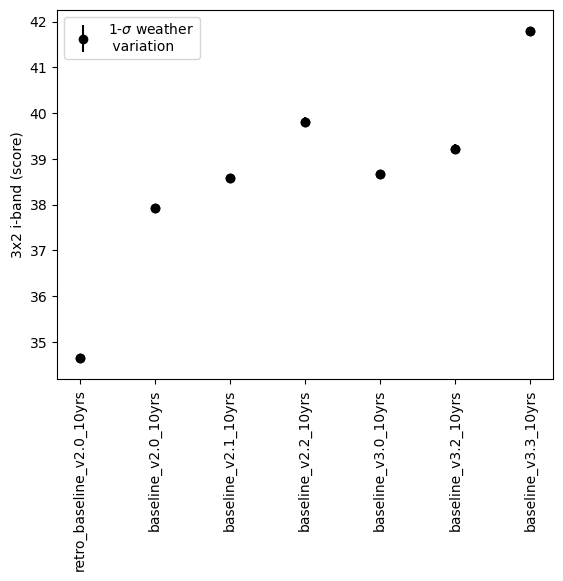

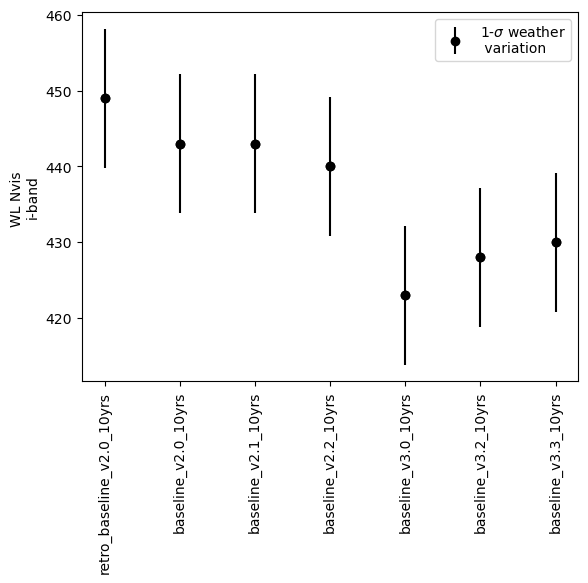

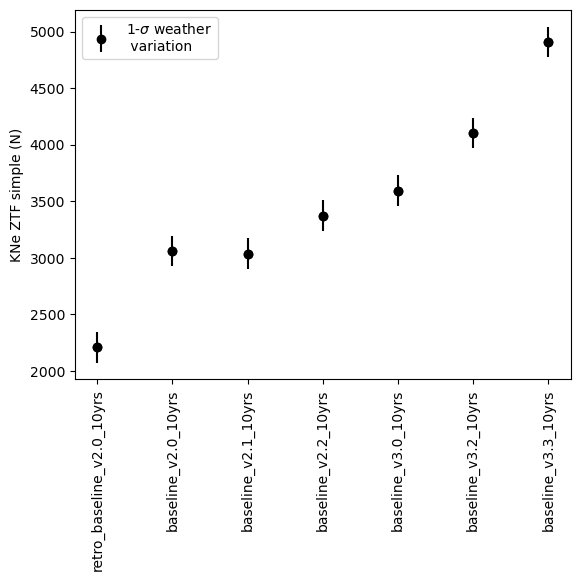

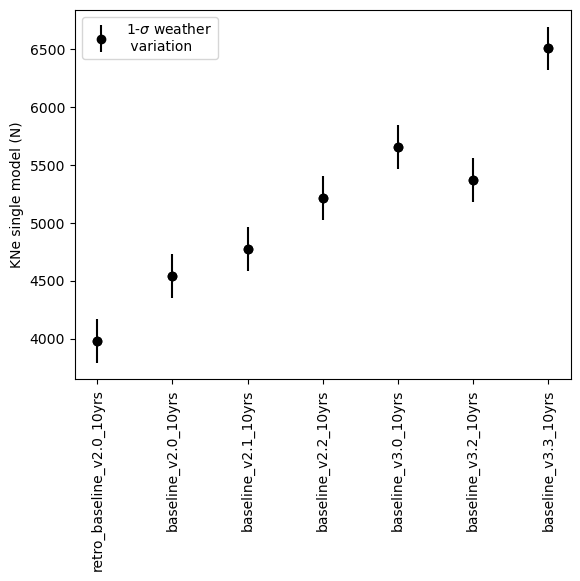

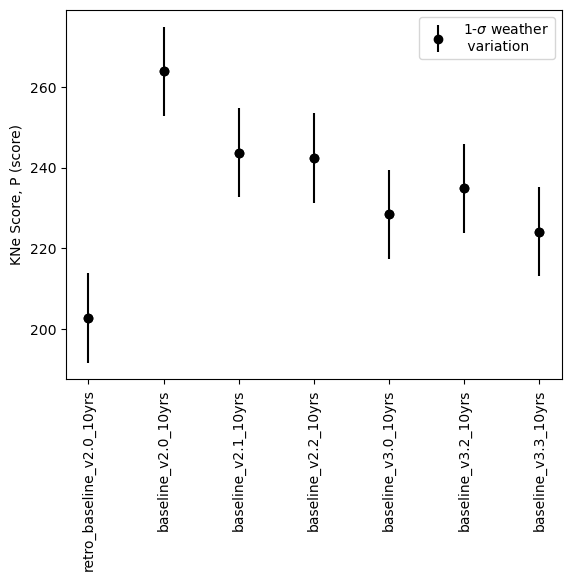

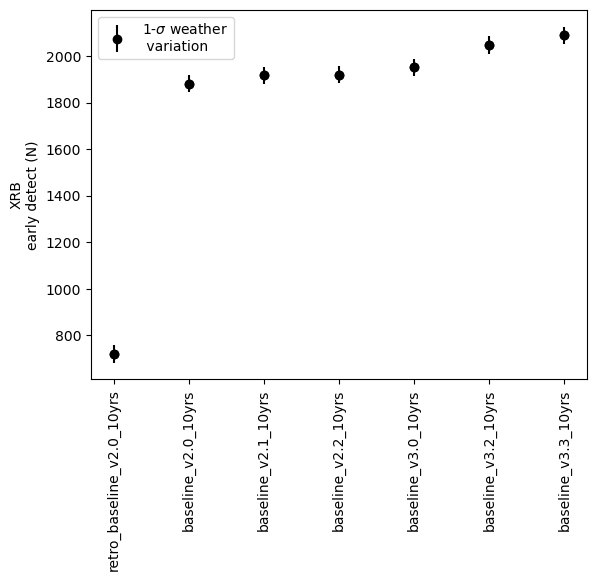

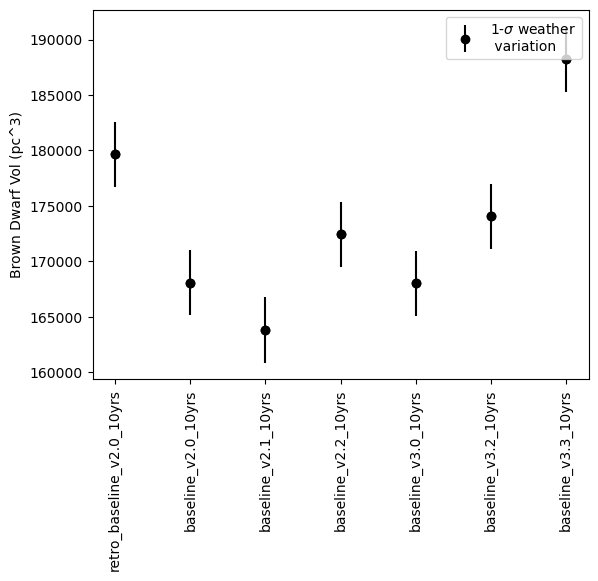

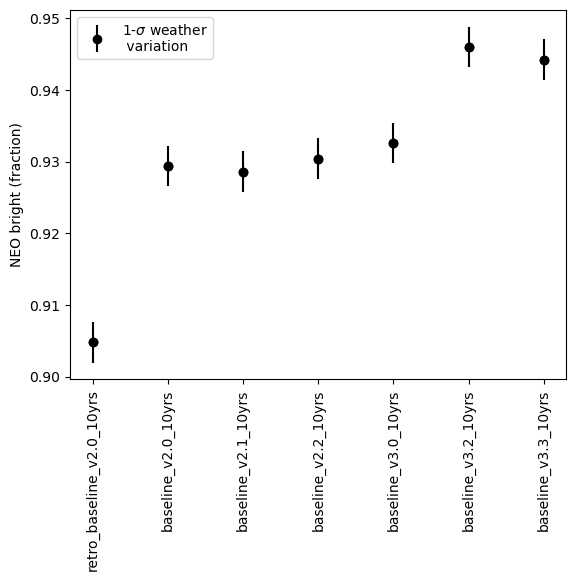

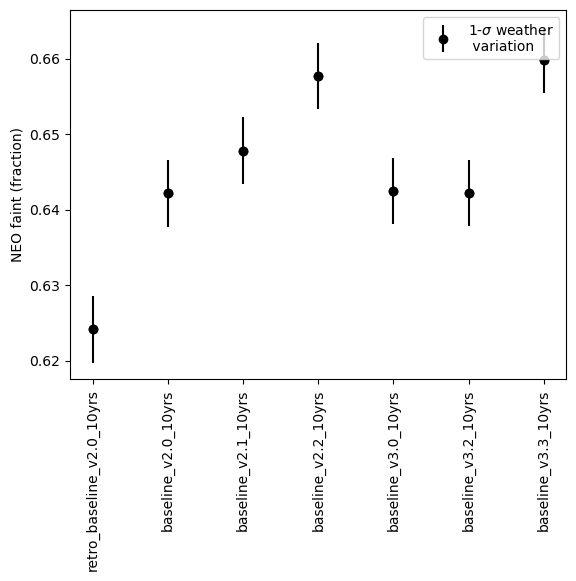

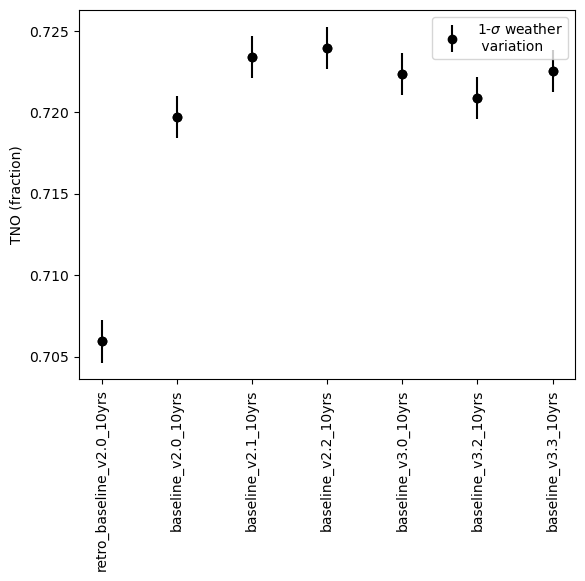

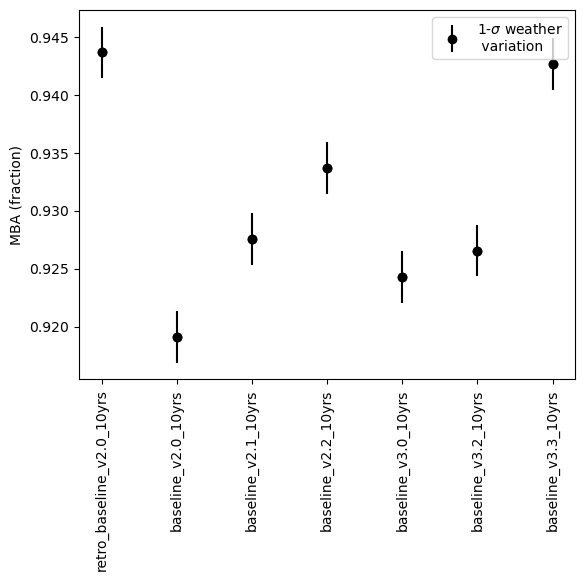

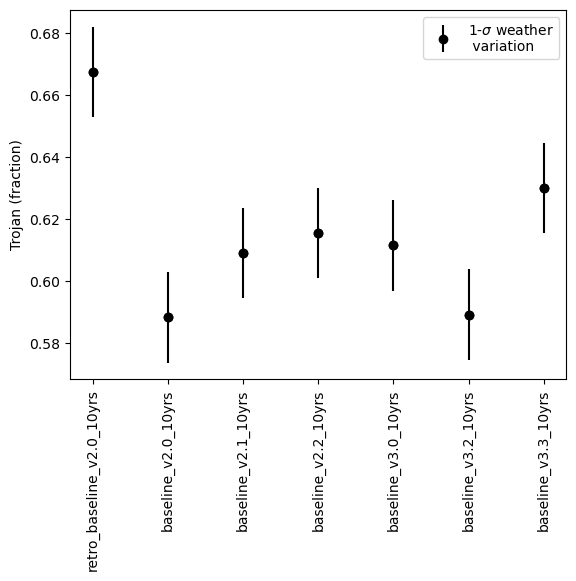

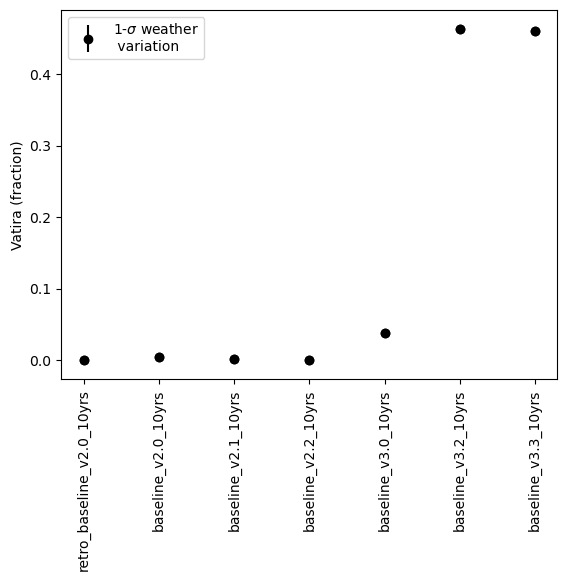

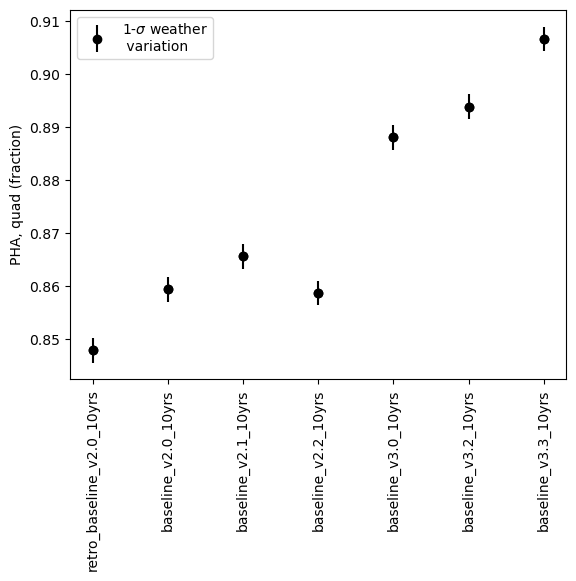

In [17]:
# Rough error bars from weather simulations
std_dict = {}
weather_runs = [run for run in data.index if 'weather' in run]
for col in data.columns:
    std_dict[col] = np.std(data.loc[weather_runs][col])

std_mag_dict = {}
for col in mag_data.columns:
    std_mag_dict[col] = np.std(mag_data.loc[weather_runs][col])
    
std_ddf_dict = {}
for col in ddf_data.columns:
    std_ddf_dict[col] = np.std(ddf_data.loc[weather_runs][col])
 

std_gaps_dict = {}
for col in gaps_data.columns:
    std_gaps_dict[col] = np.std(gaps_data.loc[weather_runs][col])


#col = data.columns[0]
for col in sub_data.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_data[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    if units[col] != '':
        label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_48677/1073381334.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col]/n, yerr=std_dict[col]/n, fmt='s', color='k',


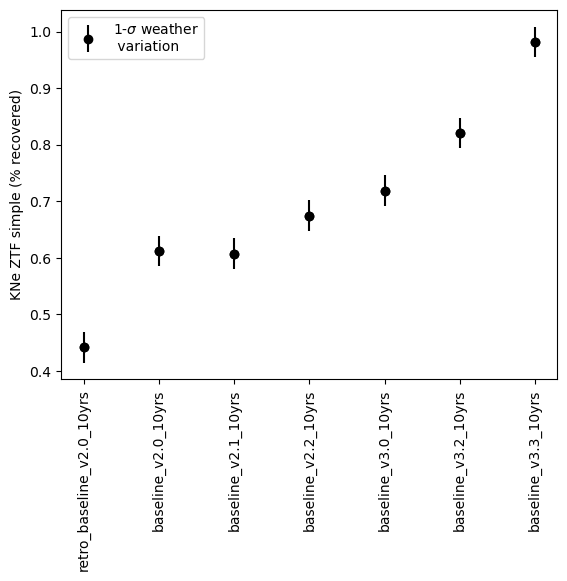

In [18]:
#col = data.columns[0]
n=500000/100
for col in ['KNe ZTF simple']:
    fig, ax = plt.subplots()
    ax.plot(sub_data[col]/n, 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col]/n, yerr=std_dict[col]/n, fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    if units[col] != '':
        label_add = ' (% recovered)'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_48677/1292493311.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',


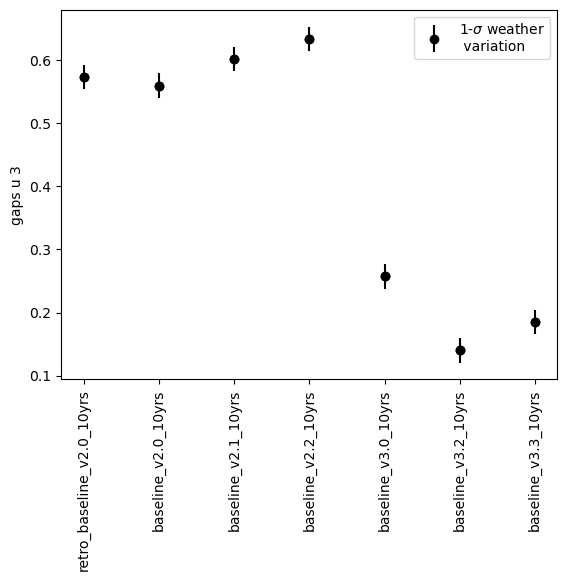

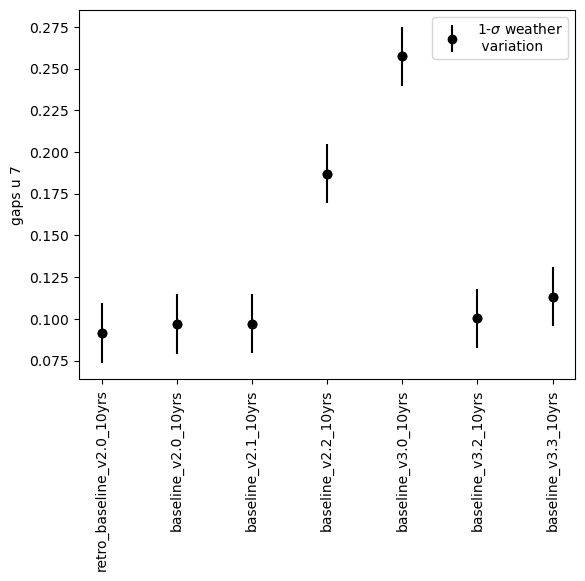

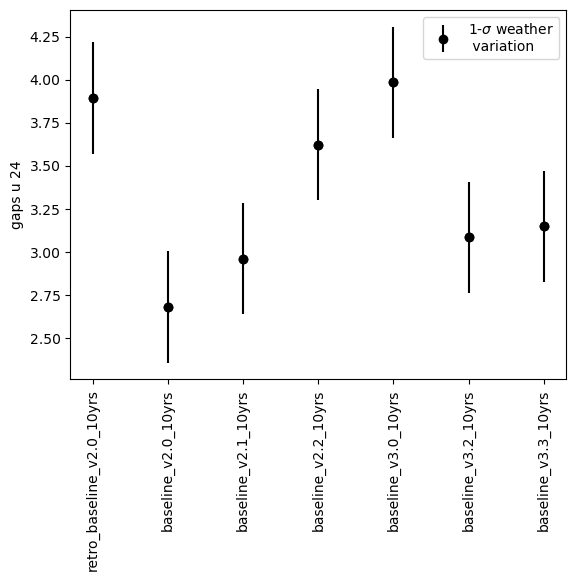

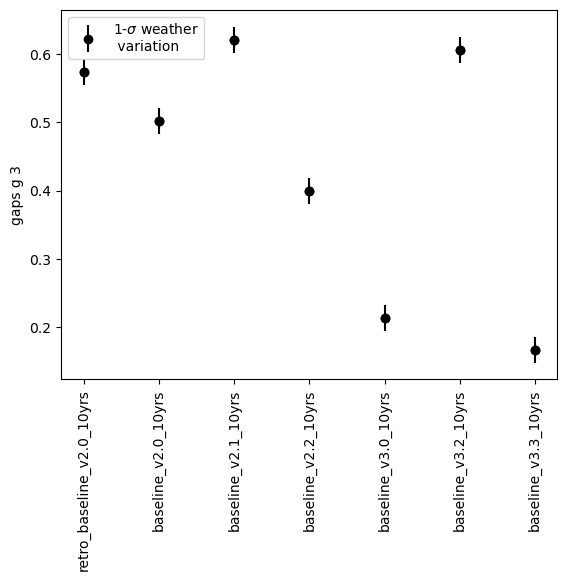

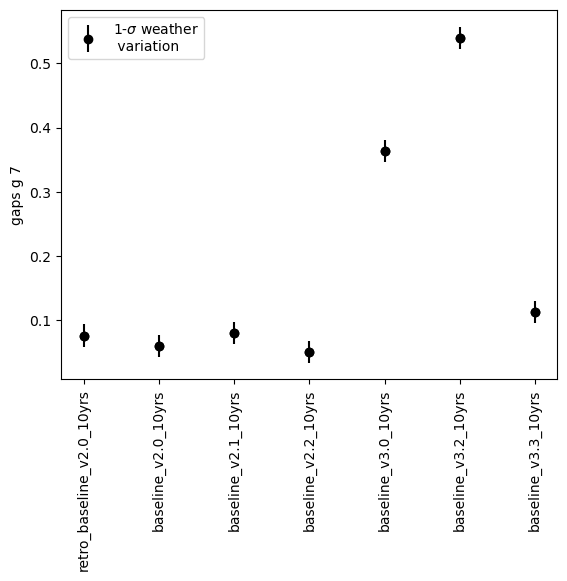

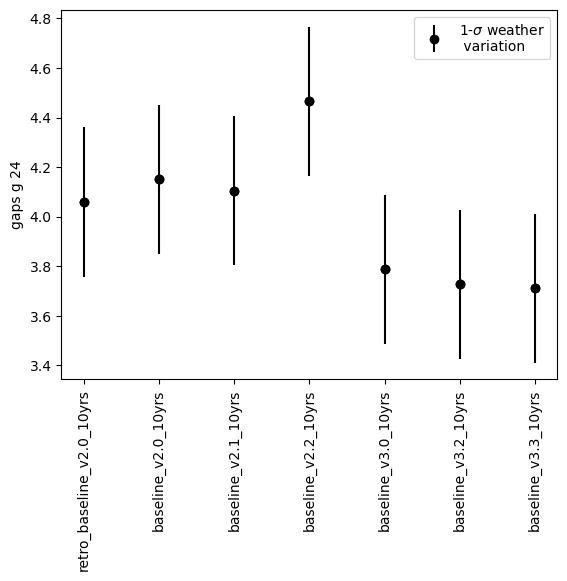

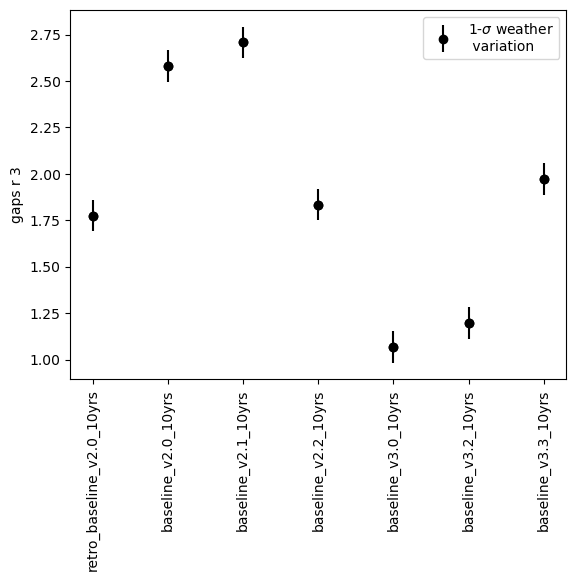

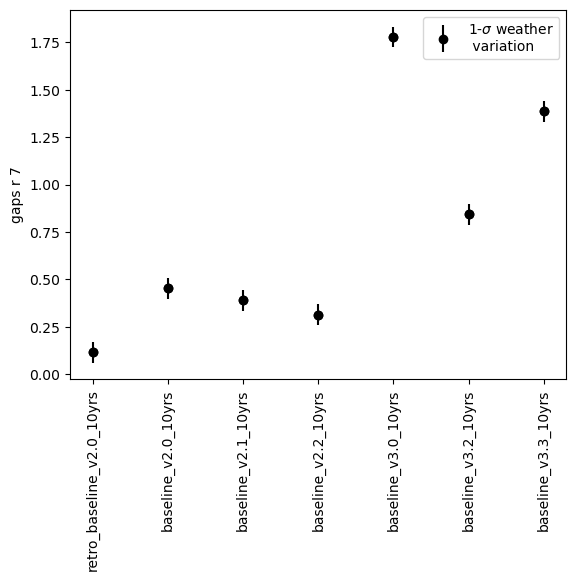

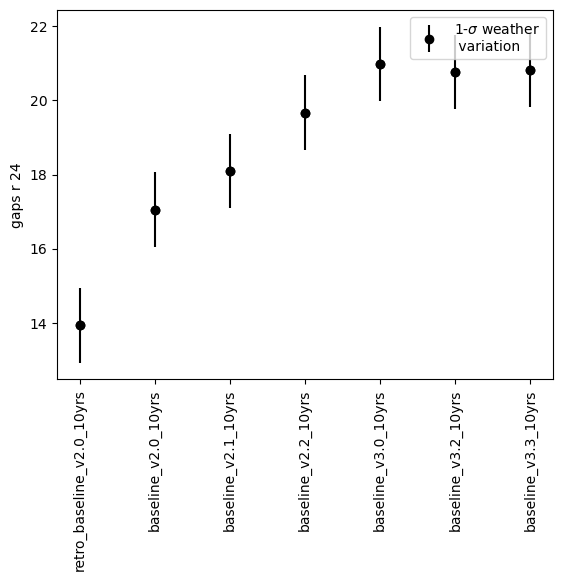

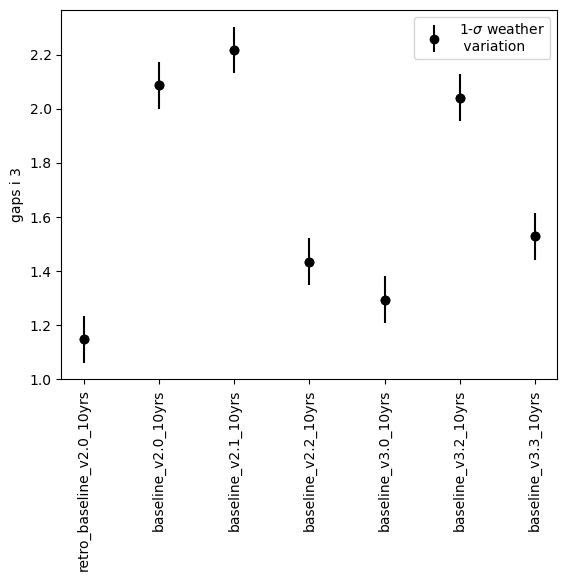

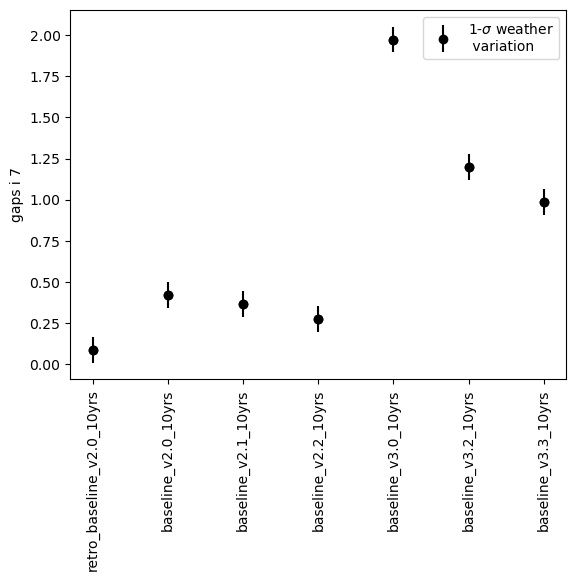

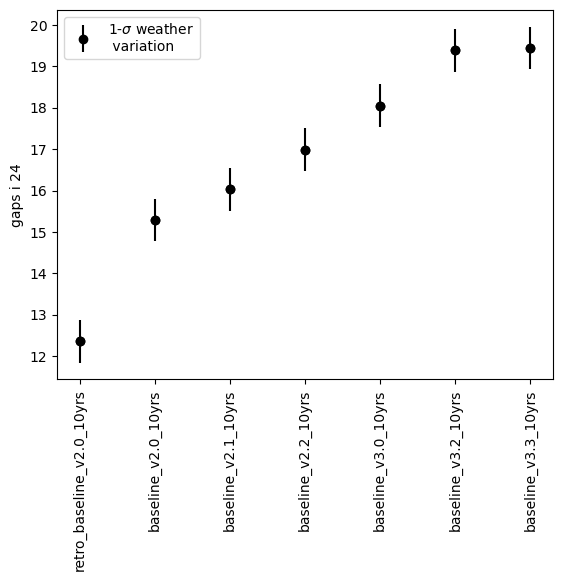

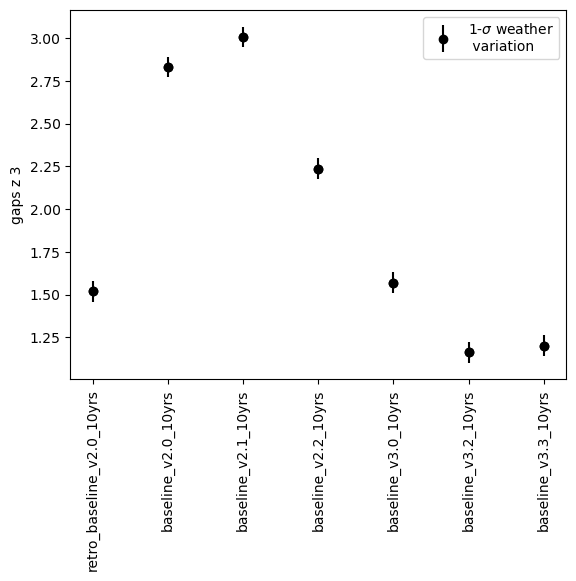

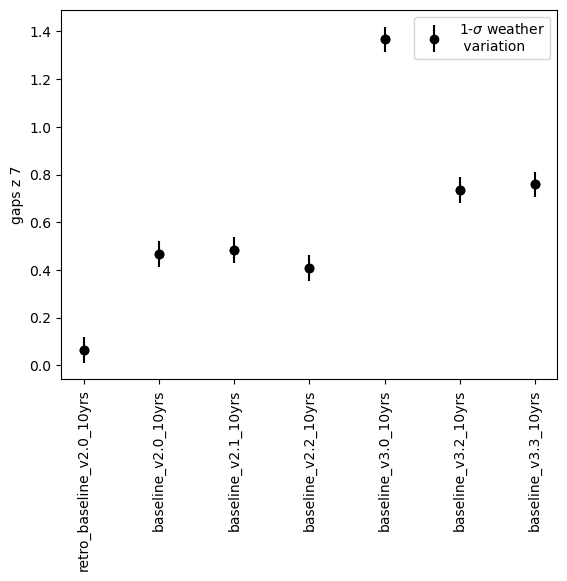

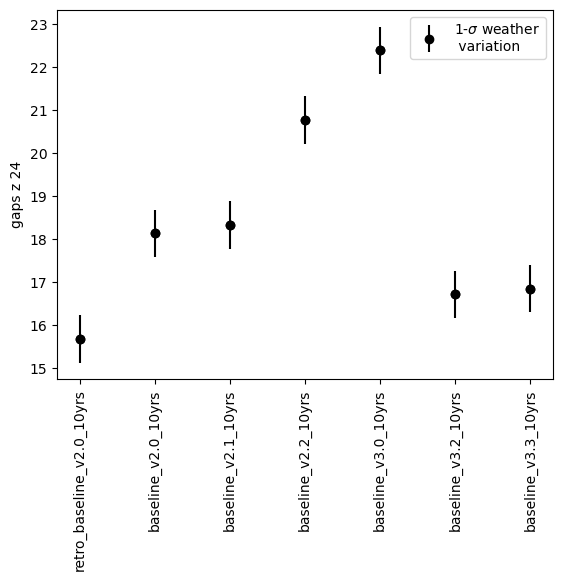

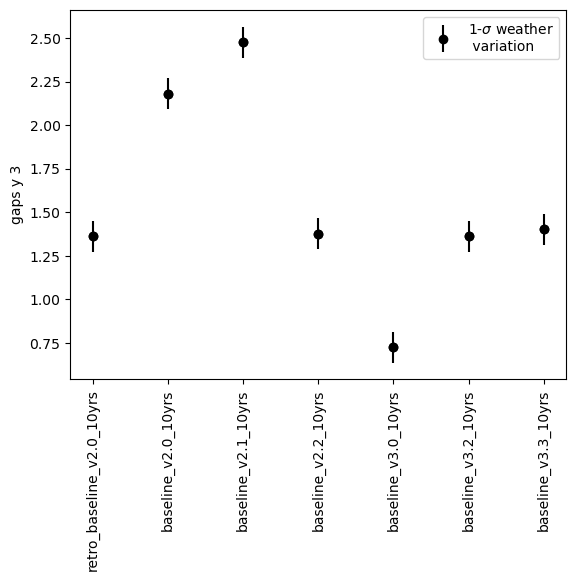

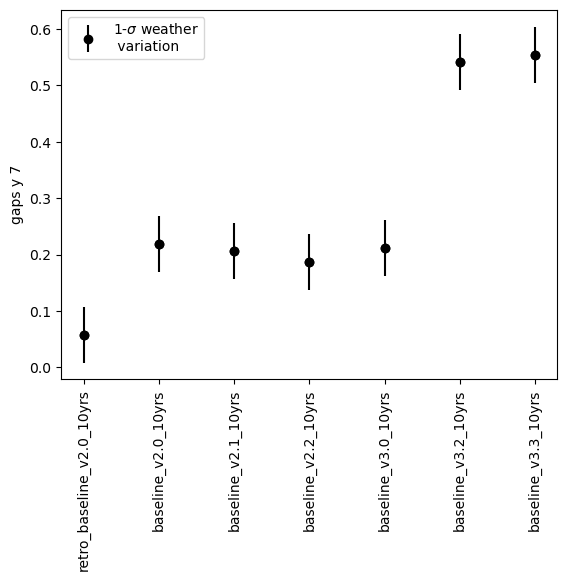

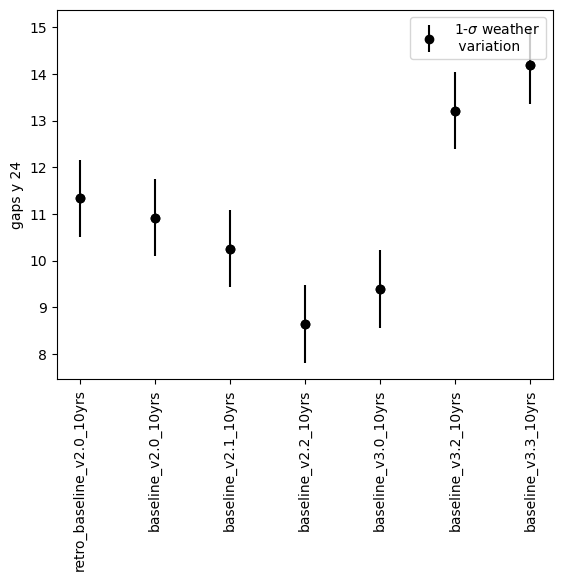

In [19]:
for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_48677/1300353735.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_ddf_dict[col], fmt='s', color='k',


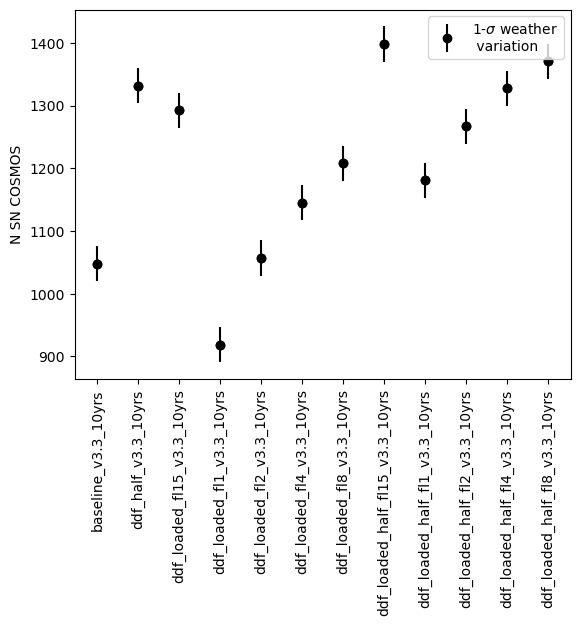

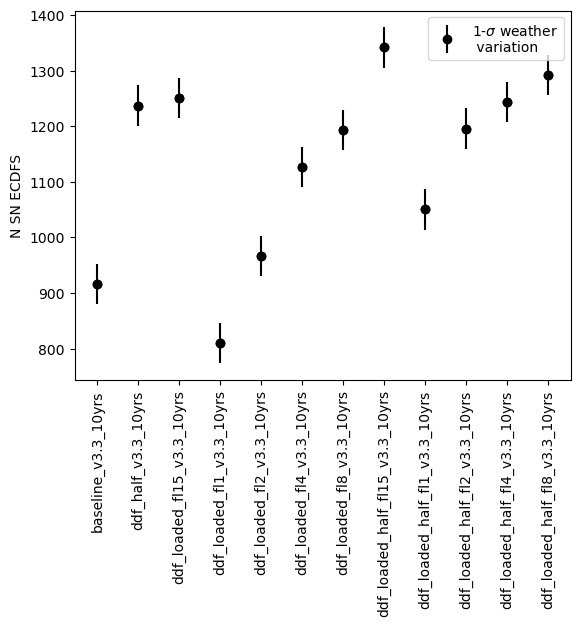

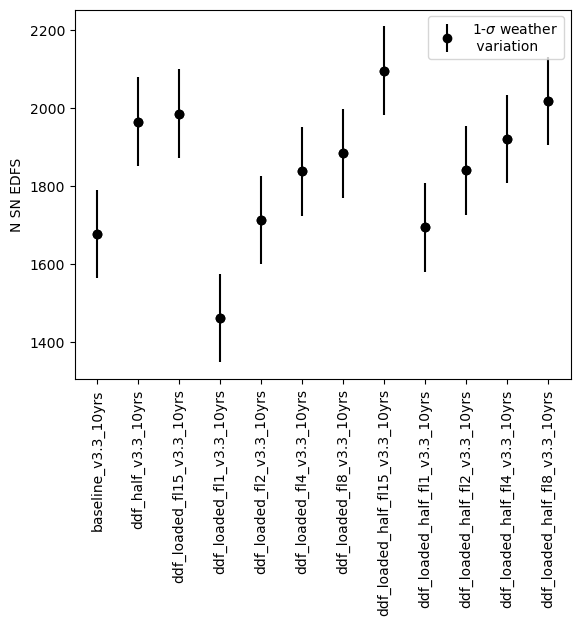

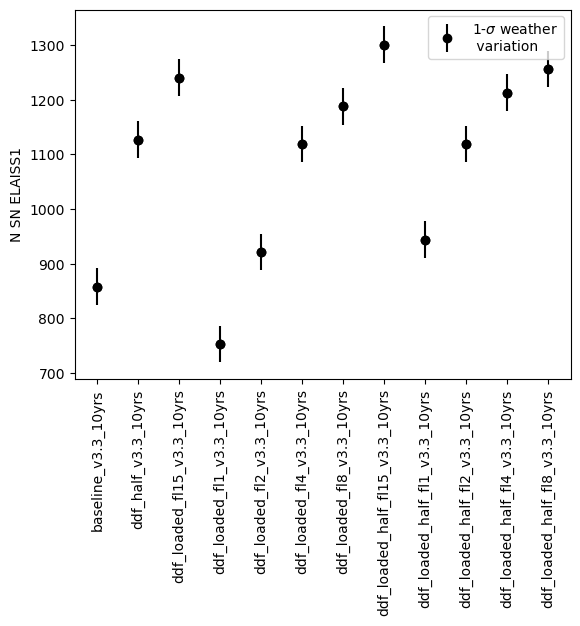

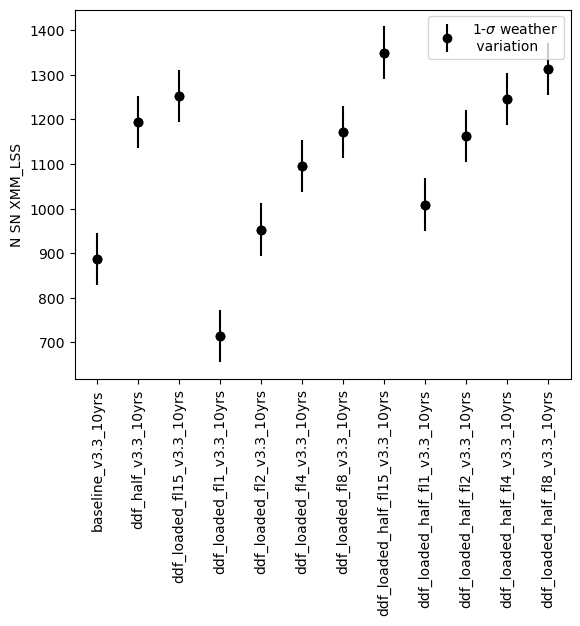

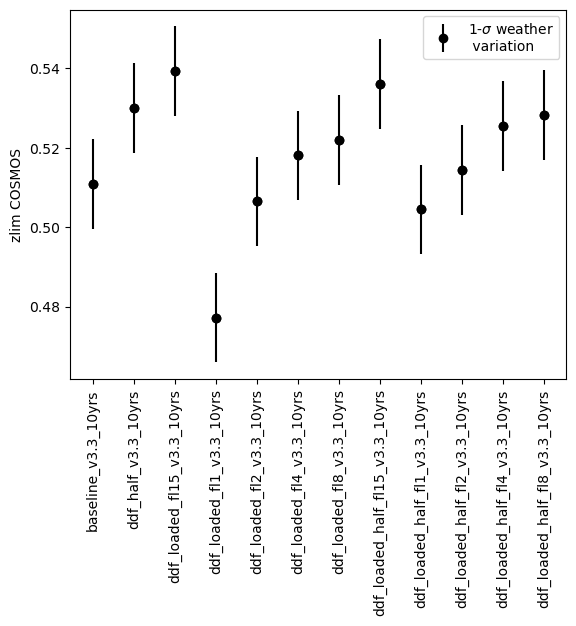

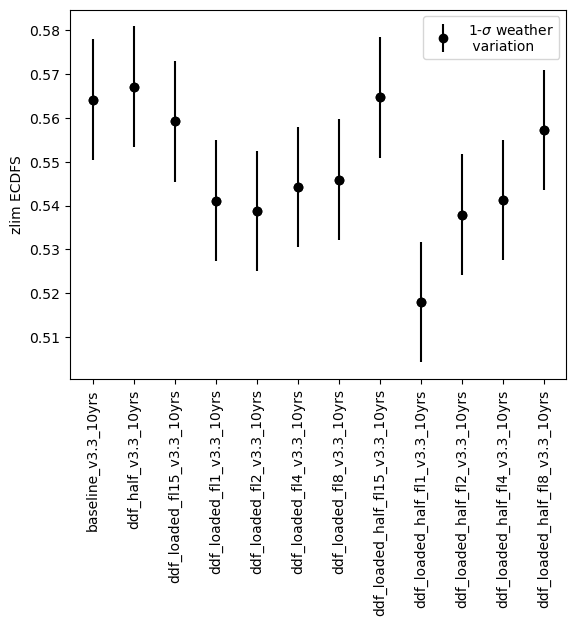

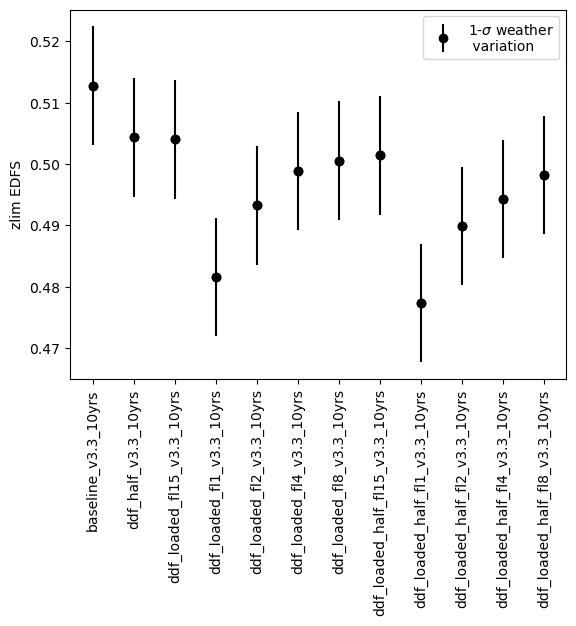

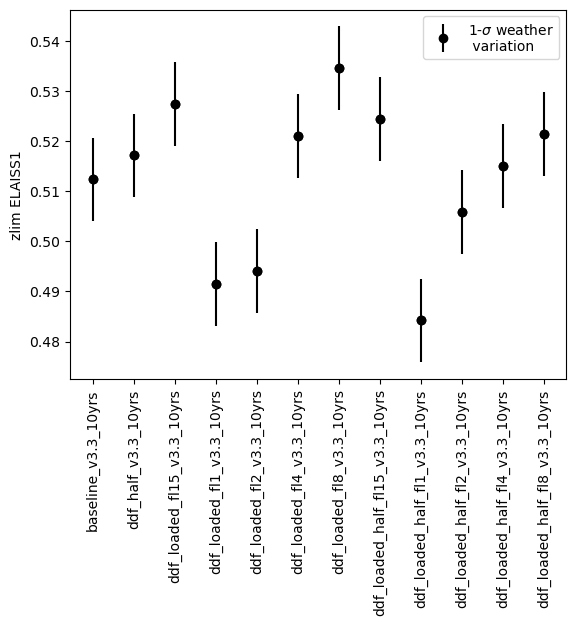

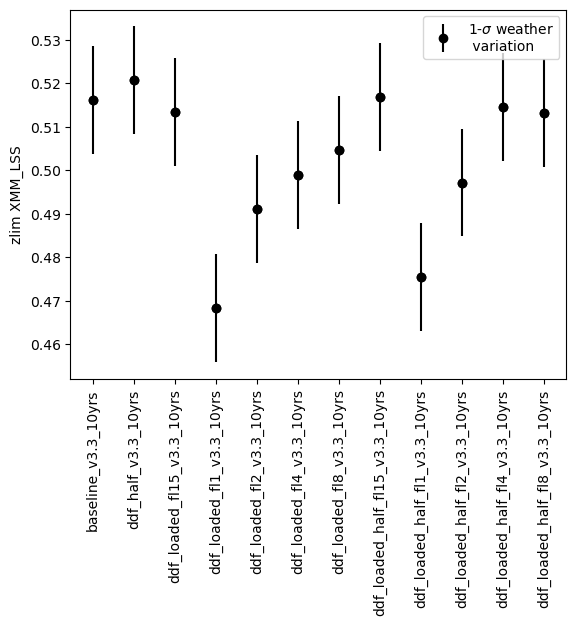

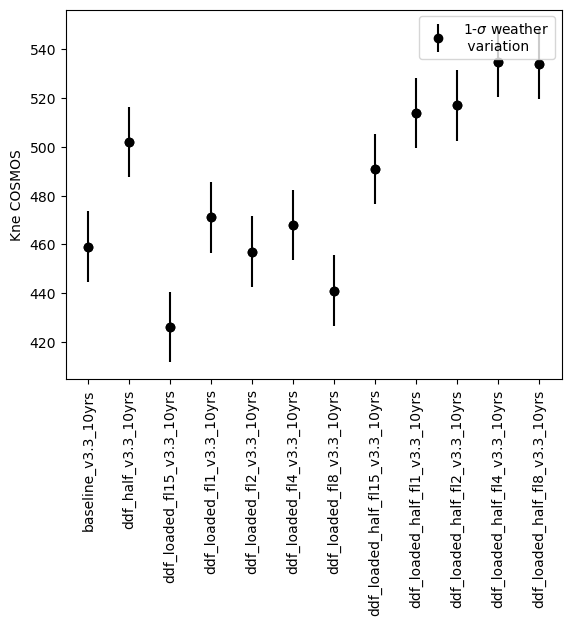

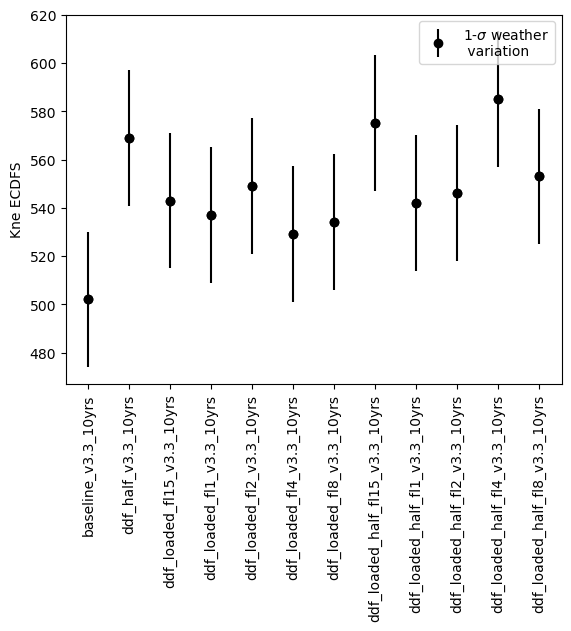

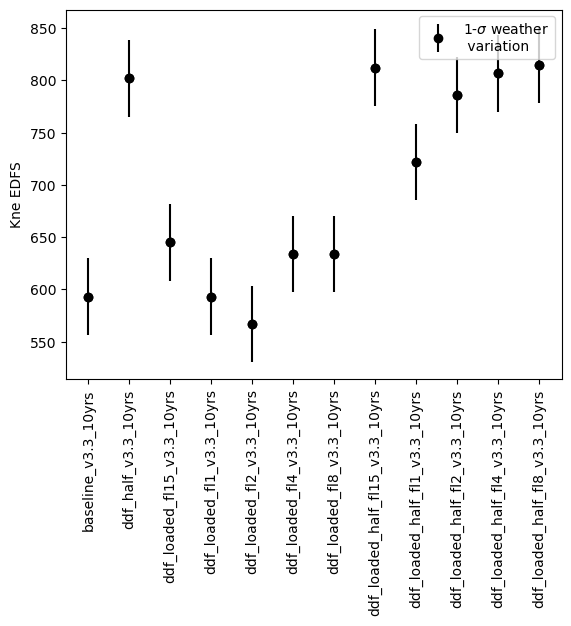

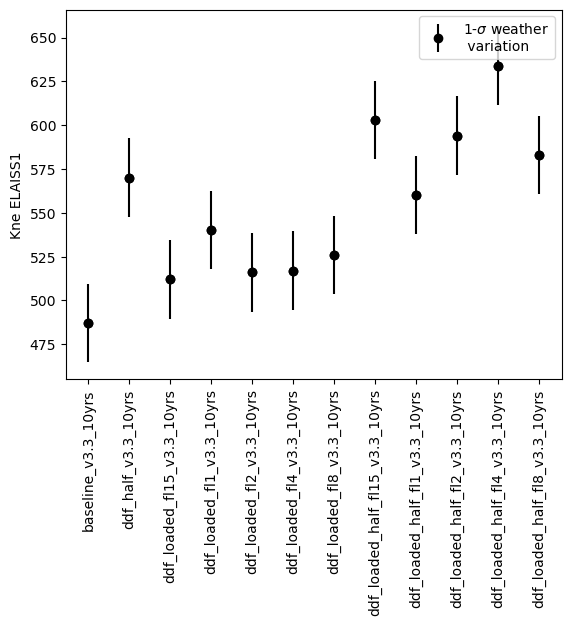

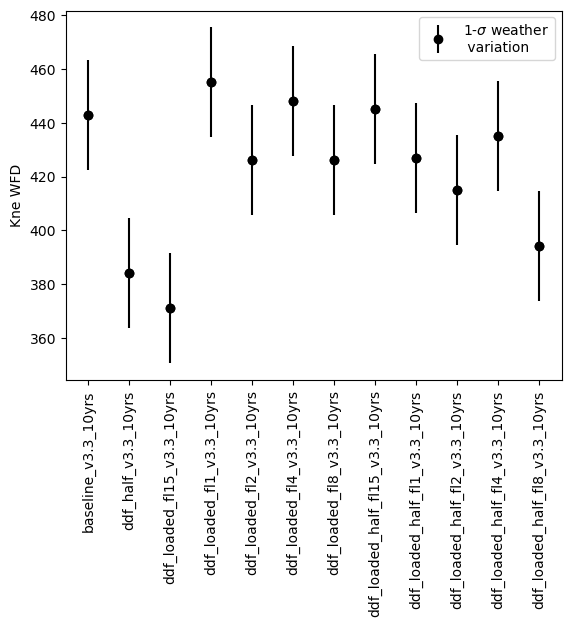

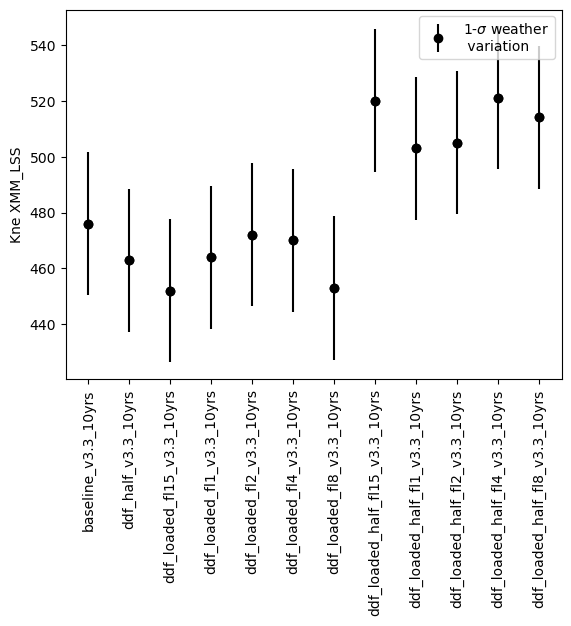

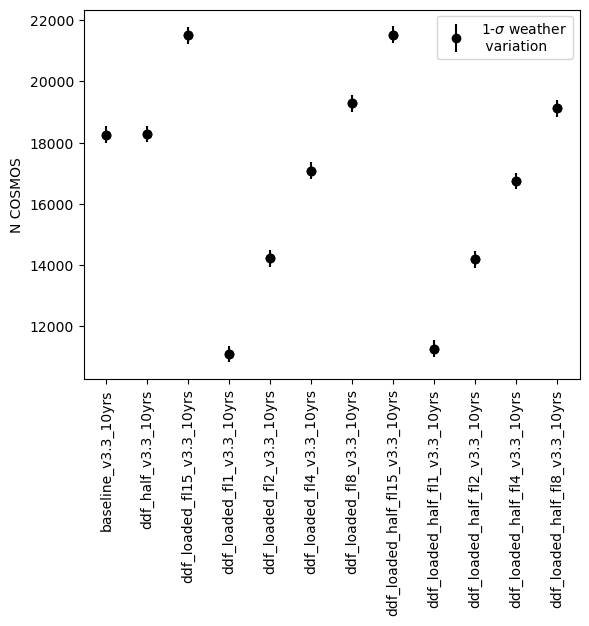

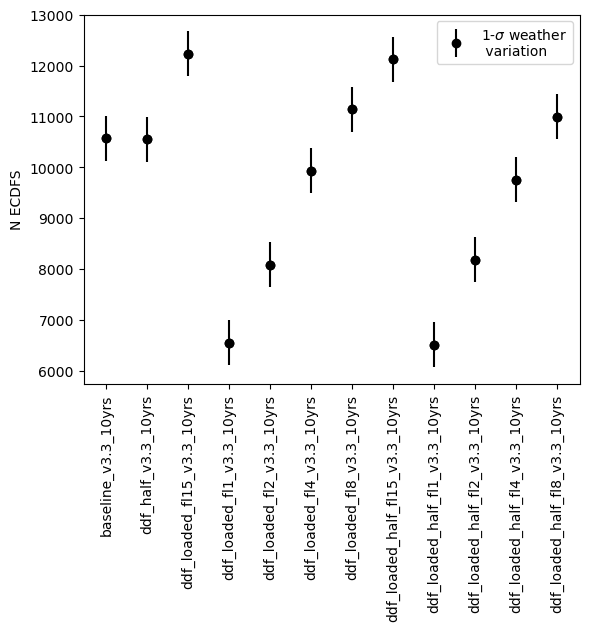

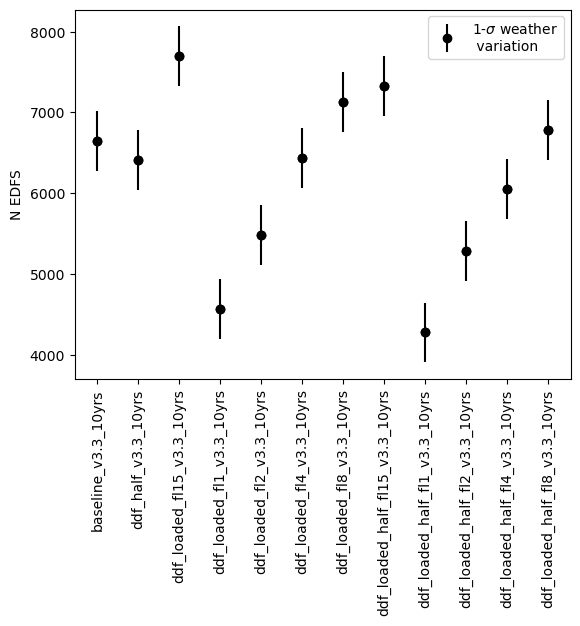

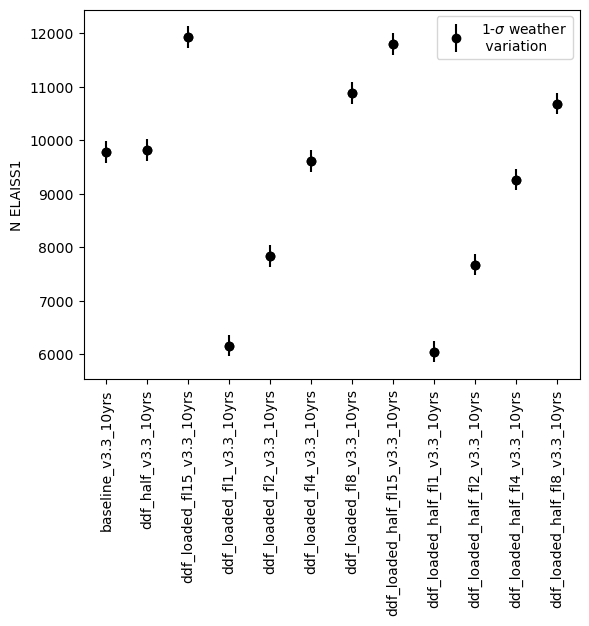

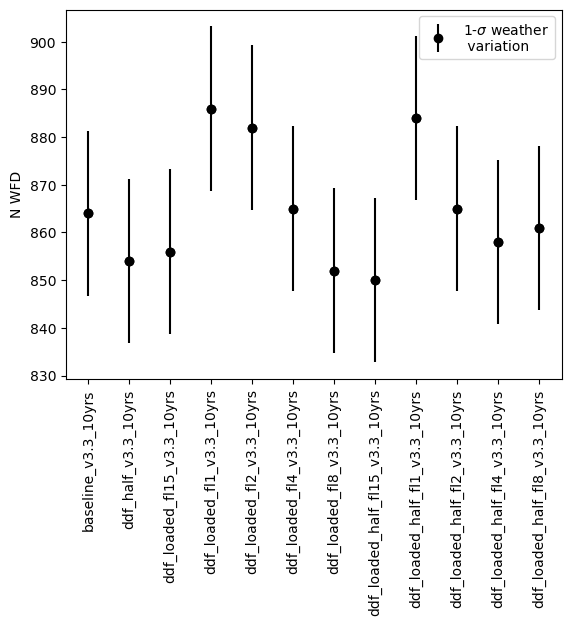

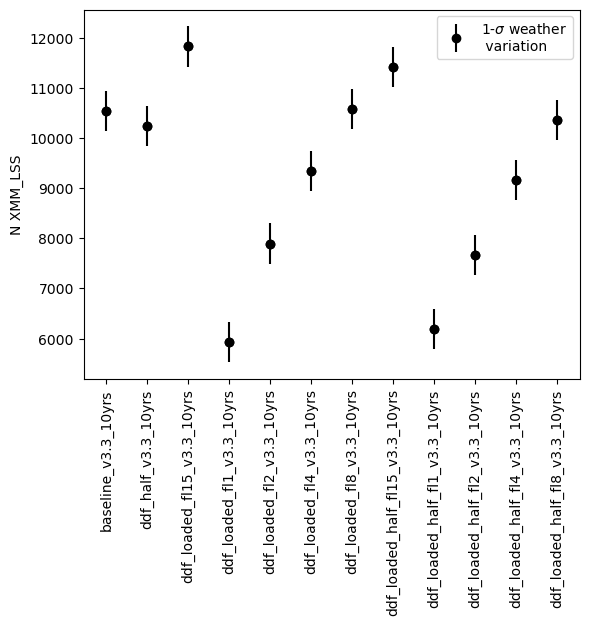

In [20]:
times = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'ddf' in run and 'short' not in run]

sub_gaps = ddf_data.reindex(labels=times)



for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_ddf_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

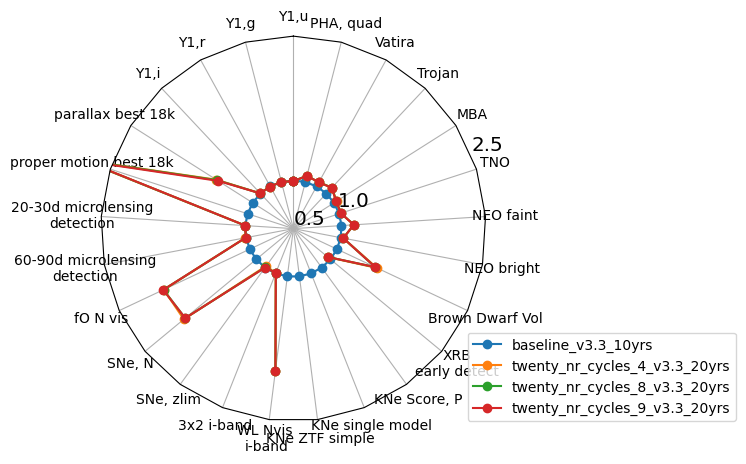

In [21]:
# Note the microlensing, XRB, and KNe metrics default to spreading objects over 10 years, 
# so those shouldn't change change.

runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'twenty' in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.5, 1.0, 2.5], bbox_to_anchor=(1.65, 0))

In [22]:
data.loc[runs]['KNe single model']

baseline_v3.3_10yrs              6506.0
twenty_nr_cycles_4_v3.3_20yrs     134.0
twenty_nr_cycles_8_v3.3_20yrs     134.0
twenty_nr_cycles_9_v3.3_20yrs     134.0
Name: KNe single model, dtype: float64

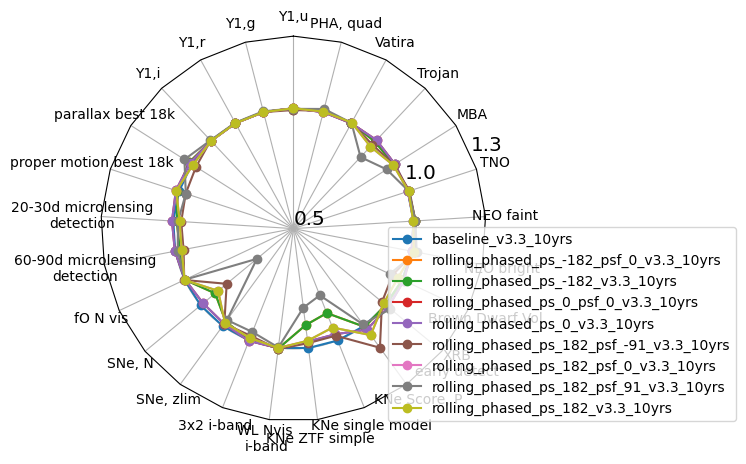

In [23]:
runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'rolling_phase' in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.5, 1.0, 1.3], bbox_to_anchor=(1.65, 0))

In [24]:
data.loc[runs]['WL Nvis \ni-band']

baseline_v3.3_10yrs                         430.0
rolling_phased_ps_-182_psf_0_v3.3_10yrs     431.0
rolling_phased_ps_-182_v3.3_10yrs           431.0
rolling_phased_ps_0_psf_0_v3.3_10yrs        430.0
rolling_phased_ps_0_v3.3_10yrs              430.0
rolling_phased_ps_182_psf_-91_v3.3_10yrs    432.0
rolling_phased_ps_182_psf_0_v3.3_10yrs      430.0
rolling_phased_ps_182_psf_91_v3.3_10yrs     429.0
rolling_phased_ps_182_v3.3_10yrs            430.0
Name: WL Nvis \ni-band, dtype: float64

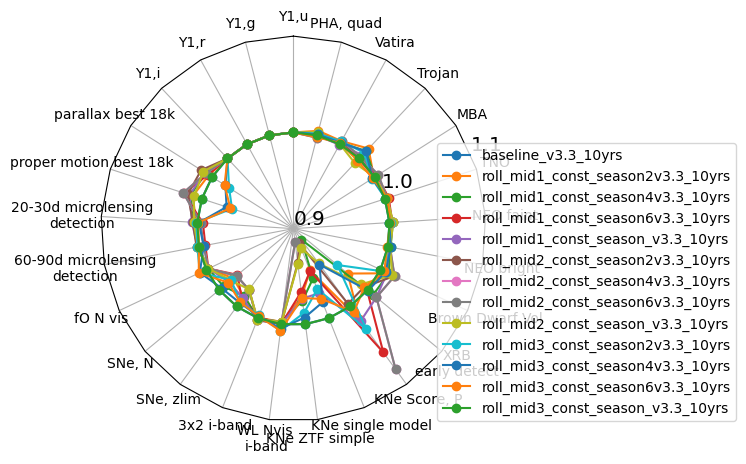

In [25]:
runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'roll_mid' in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

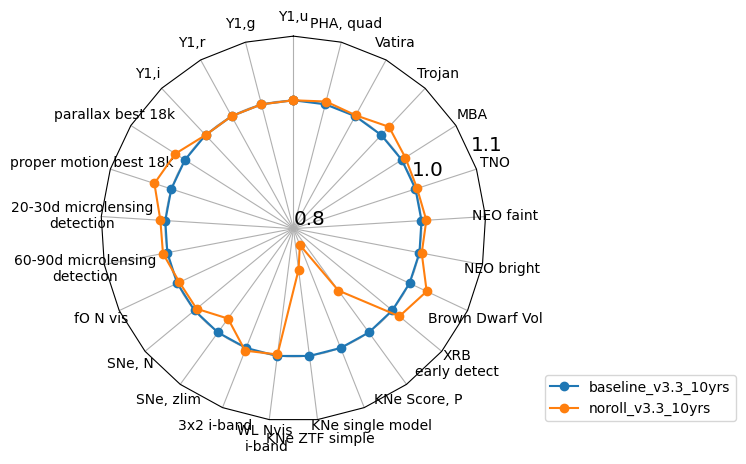

In [26]:
runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'noroll' in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

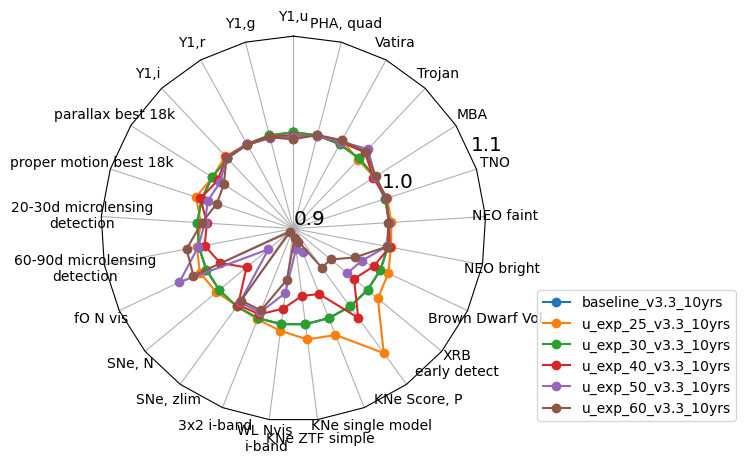

In [27]:
runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'u_exp' in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

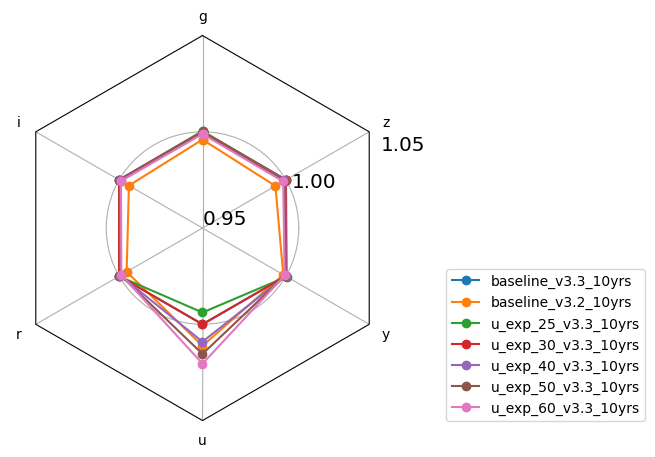

In [28]:
runs = ['baseline_v3.3_10yrs','baseline_v3.2_10yrs'] + [run for run in data.index if 'u_exp' in run]

ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                 mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.95, 1.0, 1.05], bbox_to_anchor=(1.65, 0))

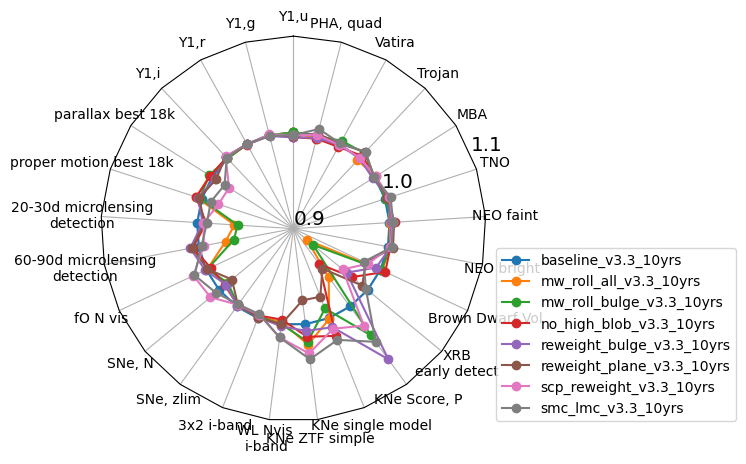

In [29]:
runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'mw' in run or 'no_high' in run or 'scp' in run
                                 or 'bulge' in run or 'plane' in run or 'smc' in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

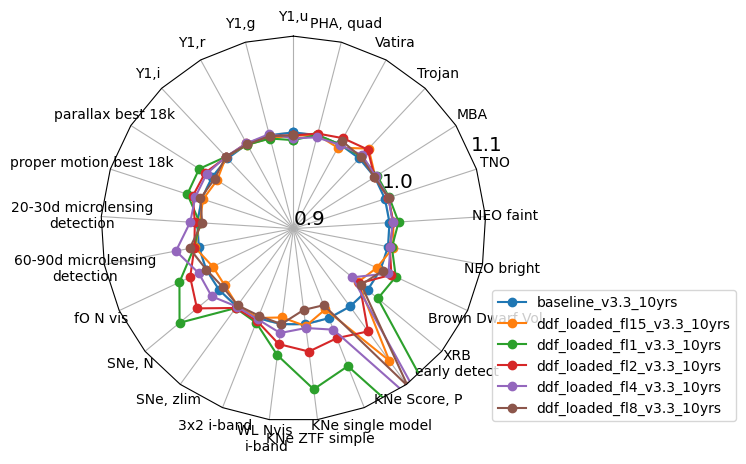

In [30]:
runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'ddf' in run and 'half' not in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

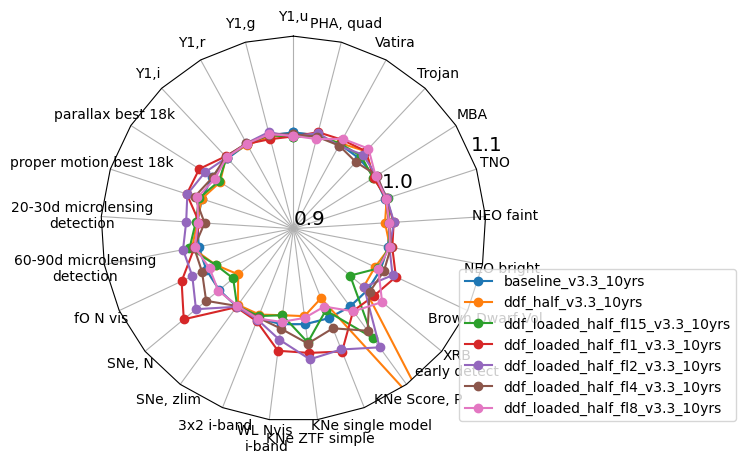

In [31]:
runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'ddf' in run and 'half' in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

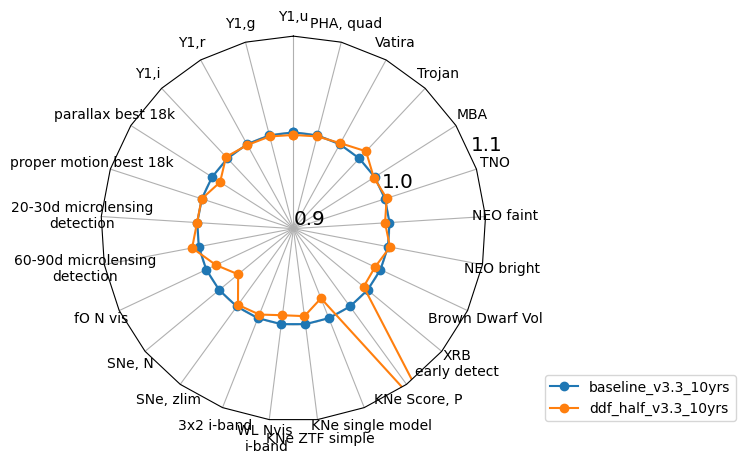

In [32]:
runs = ['baseline_v3.3_10yrs', 'ddf_half_v3.3_10yrs'] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

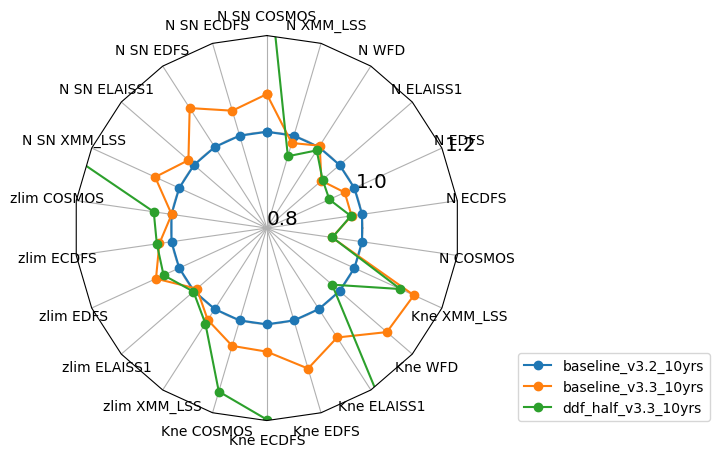

In [33]:
runs = ['baseline_v3.2_10yrs','baseline_v3.3_10yrs', 'ddf_half_v3.3_10yrs'] 

ndata = norm_df(ddf_data, runs, cols=ddf_data.columns.values.tolist(),
                invert_cols=None, mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.2], bbox_to_anchor=(1.65, 0))

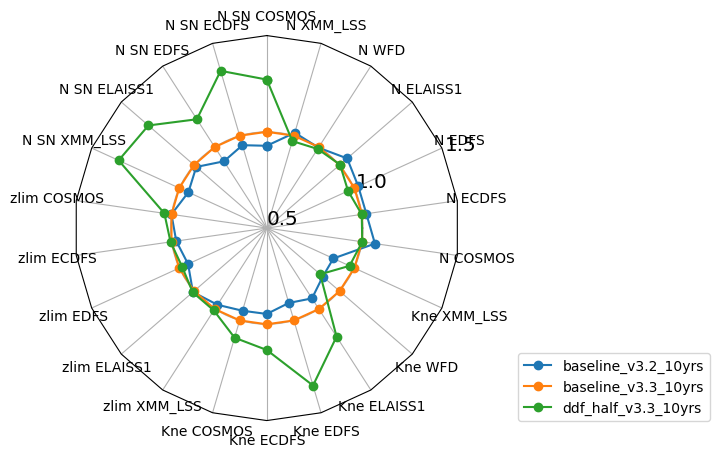

In [34]:
ndata = norm_df(ddf_data, runs, cols=ddf_data.columns.values.tolist(),
                invert_cols=None, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.5, 1.0, 1.5], bbox_to_anchor=(1.65, 0))

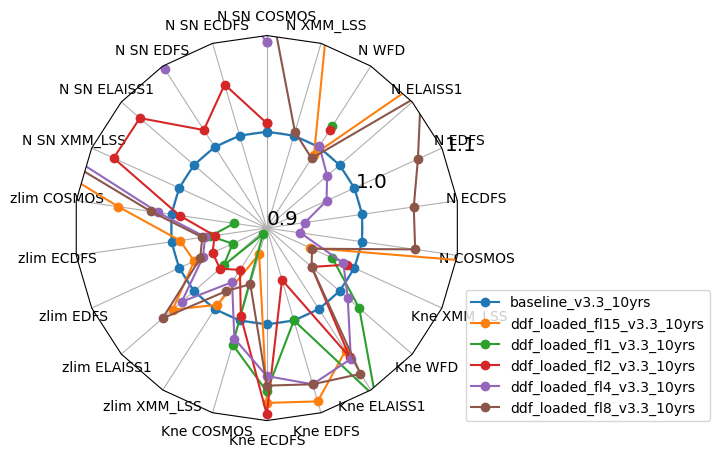

In [35]:
runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'ddf' in run and 'half' not in run]


ndata = norm_df(ddf_data, runs, cols=ddf_data.columns.values.tolist(),
                invert_cols=None, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

In [36]:
ndata

N SN COSMOS  N SN ECDFS  N SN EDFS  N SN ELAISS1  \
baseline_v3.3_10yrs            1.000000    1.000000   1.000000      1.000000   
ddf_loaded_fl15_v3.3_10yrs     1.233581    1.366544   1.184222      1.446115   
ddf_loaded_fl1_v3.3_10yrs      0.876722    0.884294   0.871173      0.877466   
ddf_loaded_fl2_v3.3_10yrs      1.008953    1.055404   1.021026      1.074489   
ddf_loaded_fl4_v3.3_10yrs      1.093244    1.229841   1.095889      1.304879   
ddf_loaded_fl8_v3.3_10yrs      1.152797    1.303223   1.123134      1.384754   

                            N SN XMM_LSS  zlim COSMOS  zlim ECDFS  zlim EDFS  \
baseline_v3.3_10yrs             1.000000     1.000000    1.000000   1.000000   
ddf_loaded_fl15_v3.3_10yrs      1.411999     1.055783    0.991144   0.982866   
ddf_loaded_fl1_v3.3_10yrs       0.805145     0.934243    0.959159   0.939079   
ddf_loaded_fl2_v3.3_10yrs       1.074935     0.991543    0.954882   0.961873   
ddf_loaded_fl4_v3.3_10yrs       1.236102     1.014247    0.964710   0.972901   
ddf_loaded_fl8_v3.3_10yrs       1.321653     1.021825    0.967657   0.976137   

                            zlim ELAISS1  zlim XMM_LSS  ...  Kne EDFS  \
baseline_v3.3_10yrs             1.000000      1.000000  ...  1.000000   
ddf_loaded_fl15_v3.3_10yrs      1.029384      0.994822  ...  1.087690   
ddf_loaded_fl1_v3.3_10yrs       0.959166      0.907295  ...  1.000000   
ddf_loaded_fl2_v3.3_10yrs       0.964387      0.951662  ...  0.956155   
ddf_loaded_fl4_v3.3_10yrs       1.017000      0.966765  ...  1.069140   
ddf_loaded_fl8_v3.3_10yrs       1.043299      0.977785  ...  1.069140   

                            Kne ELAISS1   Kne WFD  Kne XMM_LSS  N COSMOS  \
baseline_v3.3_10yrs            1.000000  1.000000     1.000000  1.000000   
ddf_loaded_fl15_v3.3_10yrs     1.051335  0.837472     0.949580  1.177732   
ddf_loaded_fl1_v3.3_10yrs      1.108830  1.027088     0.974790  0.607414   
ddf_loaded_fl2_v3.3_10yrs      1.059548  0.961625     0.991597  0.778520   
ddf_loaded_fl4_v3.3_10yrs      1.061602  1.011287     0.987395  0.935363   
ddf_loaded_fl8_v3.3_10yrs      1.080082  0.961625     0.951681  1.055740   

                             N ECDFS    N EDFS  N ELAISS1     N WFD  N XMM_LSS  
baseline_v3.3_10yrs         1.000000  1.000000   1.000000  1.000000   1.000000  
ddf_loaded_fl15_v3.3_10yrs  1.157158  1.156969   1.218871  0.990741   1.122155  
ddf_loaded_fl1_v3.3_10yrs   0.619690  0.685762   0.630035  1.025463   0.562026  
ddf_loaded_fl2_v3.3_10yrs   0.764973  0.823936   0.801574  1.020833   0.748957  
ddf_loaded_fl4_v3.3_10yrs   0.940013  0.968275   0.982928  1.001157   0.886571  
ddf_loaded_fl8_v3.3_10yrs   1.054262  1.072621   1.111736  0.986111   1.003983  

[6 rows x 22 columns]

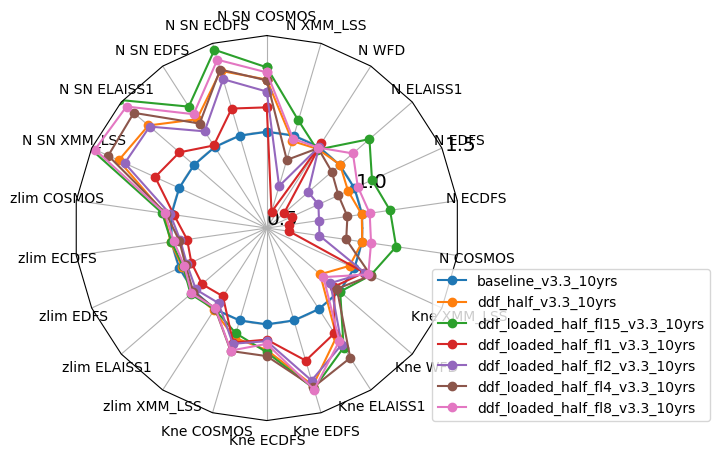

In [37]:
runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'ddf' in run and 'half' in run]


ndata = norm_df(ddf_data, runs, cols=ddf_data.columns.values.tolist(),
                invert_cols=None, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.5, 1.0, 1.5], bbox_to_anchor=(1.65, 0))

In [38]:

sub_mag




g          i          r          u  \
retro_baseline_v2.0_10yrs  26.835006  26.308518  26.850968  25.707301   
baseline_v2.0_10yrs        26.733479  26.218659  26.755971  25.818916   
baseline_v2.1_10yrs        26.736248  26.252054  26.781543  25.751969   
baseline_v2.2_10yrs        26.753646  26.290929  26.835430  25.724699   
baseline_v3.0_10yrs        26.688123  26.264600  26.818287  25.668262   
baseline_v3.2_10yrs        26.678103  26.295888  26.807880  25.622696   
baseline_v3.3_10yrs        26.786124  26.451047  26.929058  25.338704   

                                   y          z  
retro_baseline_v2.0_10yrs  24.842363  25.606168  
baseline_v2.0_10yrs        24.762720  25.510379  
baseline_v2.1_10yrs        24.728145  25.486640  
baseline_v2.2_10yrs        24.782743  25.581317  
baseline_v3.0_10yrs        24.756955  25.524781  
baseline_v3.2_10yrs        24.766647  25.586860  
baseline_v3.3_10yrs        24.805181  25.748060

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_48677/2717096801.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_mag[col].values.size), sub_mag[col], yerr=std_mag_dict[col], fmt='s', color='k',


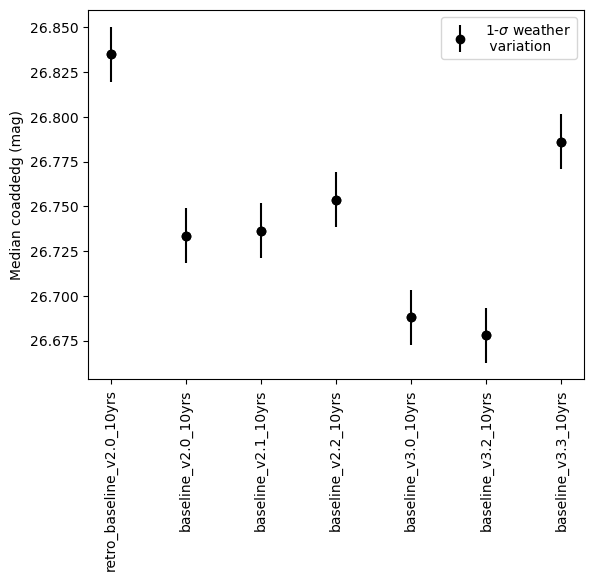

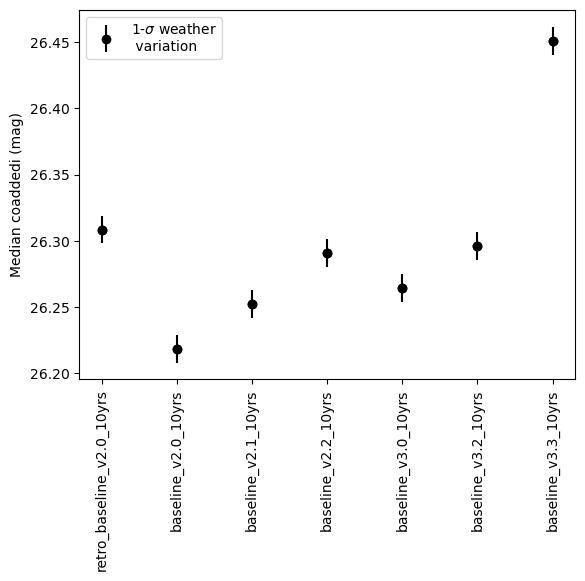

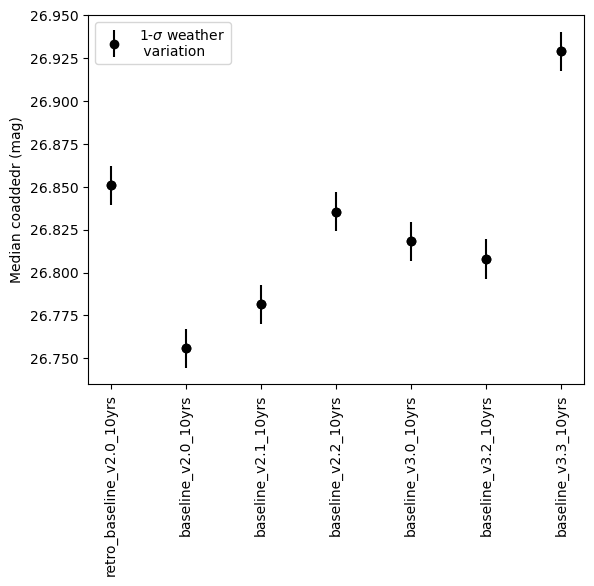

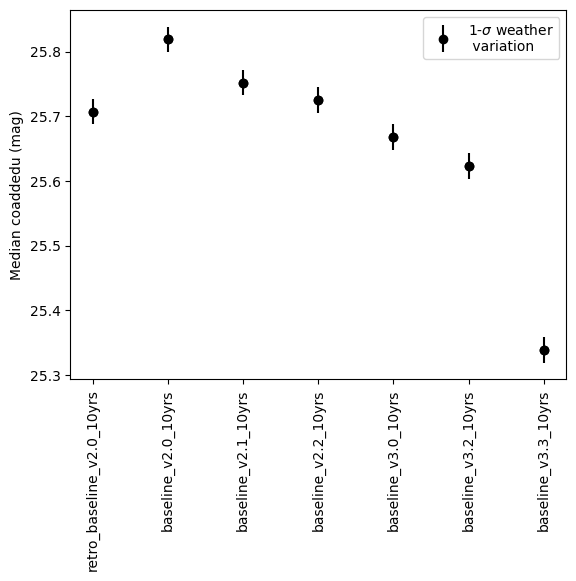

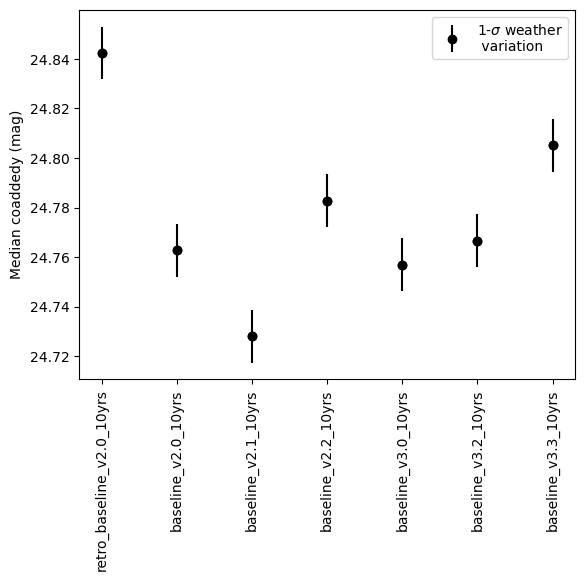

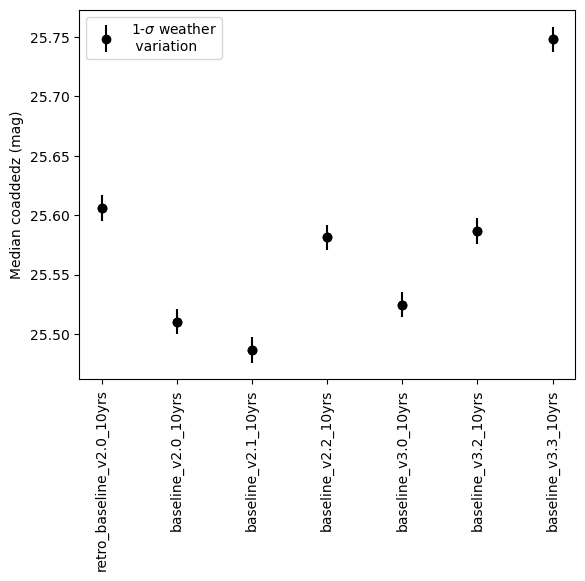

In [39]:
# Rough error bars from weather simulations

#col = data.columns[0]
for col in sub_mag.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_mag[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_mag[col].values.size), sub_mag[col], yerr=std_mag_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    
    label_add = ' (mag)'
    ax.set_ylabel('Median coadded' + col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])
